In [28]:
import pandas as pd
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.signal import butter, filtfilt, hilbert, correlate, deconvolve
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pickle
from scipy.interpolate import interp1d


### Some helper functions

In [2]:
def plot_power_spectrum(signal, fs, ax=None):
    n = len(signal)
    fft_signal = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, d=1/fs)
    power_spectrum = np.abs(fft_signal)**2
    positive_freqs = freqs[:n // 2]
    positive_power_spectrum = power_spectrum[:n // 2]

    if ax is None:
        ax = plt.gca()
    
    ax.plot(positive_freqs, positive_power_spectrum)
    ax.set_yscale('log')
    ax.set_title('Power Spectrum of the Signal (log scaled)')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power (log scaled)')
    ax.grid(True)
    ax.set_xlim([0, fs/2])  # Limit to Nyquist frequency

In [3]:
def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [29]:
# interested in df_data, breath, valve, pulse/odor 

data_files = {
    'HW1': {
        'ca_path': 'Data/HW1_50ms/adaptation_data_HW1_50ms_struct.mat',
        'breath_path': 'Data/HW1_50ms/HW1_50ms_0.mat'
    },
    'HW4': {
        'ca_path': 'Data/HW4_50ms_real/adaptation_data_HW4_50ms_real_struct-001.mat',
        'breath_path': 'Data/HW4_50ms_real/HW4_50ms_real_0.mat'
    },
    'Sphinx': {
        'ca_path': 'Data/Sphinx/adaptation_data_Sphinx_50ms_random_struct.mat',
        'breath_path': 'Data/Sphinx/Sphinx_50ms_random.mat'
    }
}

datasets = {}

for dataset, paths in data_files.items():

    breath_data = loadmat(paths['breath_path'])
    breath = breath_data['breath']
    valve = breath_data['valve']
    pulse = breath_data['pulse']

    # filter breath signal
    fs = 1000 
    t = np.arange(len(breath)) / fs  
    highcut =10
    breath_filt = butter_bandpass_filter(breath, highcut, fs, order=3) - np.mean(breath) #subtract mean of breath signal to make the curve symetric aroudn 0 

    with h5py.File(paths['ca_path'], 'r') as mat_file:
        imaging_struct = mat_file['imaging_struct']
        df_data = pd.DataFrame(imaging_struct['df_data'][:])

        list_array_nn_interp = []
        calcium_time = np.arange(df_data.shape[0])/10
        for i in range(len(df_data.columns)):
            calcium_roi_data = df_data.iloc[:,i]
            interp_func = interp1d(calcium_time, calcium_roi_data, kind="linear", bounds_error=False, fill_value="extrapolate")
            nn_interp = interp_func(np.arange(breath.size) / 1000)
            list_array_nn_interp.append(nn_interp)

        df_data_nn_interp = pd.DataFrame(np.array(list_array_nn_interp).T)

        datasets[dataset] = {
            'breath': {
                'breath': breath,
                'breath_filt': breath_filt,
                'valve': valve,
                'pulse': pulse
            },
            'calcium_imaging': {
                'ca': df_data,
                'ca_nn_interp': df_data_nn_interp
            }
        }

    print(f"{dataset} data stored") 

HW1 data stored
HW4 data stored
Sphinx data stored


In [5]:
with open("all_animals_data.pkl","wb") as f:
    pickle.dump(datasets,f)

In [6]:
with open("all_animals_data.pkl", "rb") as f:
    retreived_dict = pickle.load(f)
print(retreived_dict)

{'HW1': {'breath': {'breath': array([[0.27814027, 0.26482999, 0.26353143, ..., 0.        , 0.        ,
        0.        ]]), 'breath_filt': array([[-2.06388626, -1.98763522, -1.91066637, ..., -2.4542347 ,
        -2.4542347 , -2.4542347 ]]), 'valve': array([[0., 0., 0., ..., 0., 0., 0.]]), 'pulse': array([[0., 0., 0., ..., 0., 0., 0.]])}, 'calcium_imaging': {'ca':              0         1         2         3         4         5         6   \
0      0.023819  0.018162  0.011737  0.031267  0.041576  0.025834  0.044826   
1      0.018858  0.032161  0.030480  0.060123  0.053348  0.020066  0.063815   
2      0.023240  0.042044  0.039762  0.046580  0.047504 -0.005441  0.028765   
3      0.023523  0.030001  0.025756  0.047008  0.073638  0.004797  0.039966   
4      0.030514  0.052289  0.061530  0.046940  0.044228  0.004096  0.042574   
...         ...       ...       ...       ...       ...       ...       ...   
21187  0.016760  0.031136  0.045534  0.033281  0.020383  0.016297  0.035301   


#### Main Variables 

In [30]:

fs_breath = 1000 
fs_calcium = 10

animals = []
breath = []
breath_filt = []
valve_data = []
pulse_data = []
calcium_ds = []
ca_interp_ds = []

t_breath = []
t_pulse = []
t_calcium = []

for key, _ in datasets.items():

    animals.append(key)
    breath.append(datasets[key]['breath']['breath'].flatten())
    breath_filt.append(datasets[key]['breath']['breath_filt'].flatten())
    valve_data.append(datasets[key]['breath']['valve'].flatten())
    pulse_data.append(datasets[key]['breath']['pulse'].flatten())
    calcium_ds.append(datasets[key]['calcium_imaging']['ca'])
    ca_interp_ds.append(datasets[key]['calcium_imaging']['ca_nn_interp'])

    t_breath.append(np.arange(len(datasets[key]['breath']['breath'].flatten())) / fs_breath)
    t_pulse.append(np.arange(len(datasets[key]['breath']['pulse'].flatten())) / fs_breath)
    t_calcium.append(np.arange(len(datasets[key]['calcium_imaging']['ca']))/ fs_calcium)

breath_dict = dict(zip(animals, breath))
breath_filt_dict = dict(zip(animals, breath_filt))
valve_dict = dict(zip(animals, valve_data))
pulse_dict = dict(zip(animals, pulse_data))
calcium_dict = dict(zip(animals, calcium_ds))
ca_interp_dict = dict(zip(animals, ca_interp_ds))


In [7]:
print(breath_dict)
print(breath_filt_dict)
print(valve_dict)
print(pulse_dict)
print(calcium_dict)
print(ca_interp_dict)


{'HW1': array([0.27814027, 0.26482999, 0.26353143, ..., 0.        , 0.        ,
       0.        ]), 'HW4': array([0.23106734, 0.23106734, 0.22944414, ..., 0.        , 0.        ,
       0.        ]), 'Sphinx': array([2.24092127, 2.87105156, 3.24017017, ..., 0.        , 0.        ,
       0.        ])}
{'HW1': array([-2.06388626, -1.98763522, -1.91066637, ..., -2.4542347 ,
       -2.4542347 , -2.4542347 ]), 'HW4': array([-2.21131487, -2.1426129 , -2.07216999, ..., -2.66726856,
       -2.66726856, -2.66726856]), 'Sphinx': array([-0.35917839, -0.23497697, -0.11151308, ..., -3.02139447,
       -3.02139447, -3.02139447])}
{'HW1': array([0., 0., 0., ..., 0., 0., 0.]), 'HW4': array([0., 0., 0., ..., 0., 0., 0.]), 'Sphinx': array([0., 0., 0., ..., 0., 0., 0.])}
{'HW1': array([0., 0., 0., ..., 0., 0., 0.]), 'HW4': array([0., 0., 0., ..., 0., 0., 0.]), 'Sphinx': array([0., 0., 0., ..., 0., 0., 0.])}
{'HW1':              0         1         2         3         4         5         6   \
0      0.

In [8]:
"""fs_breath = 1000 
fs_calcium = 10

breath = datasets['HW1']['breath']['breath'].flatten()
breath_filt = datasets['HW1']['breath']['breath_filt'].flatten()

valve_data = datasets['HW1']['breath']['valve'].flatten()

pulse_data = datasets['HW1']['breath']['pulse'].flatten()

hw1_calcium_ds = datasets['HW1']['calcium_imaging']['ca']
hw1_ca_interp_ds = datasets['HW1']['calcium_imaging']['ca_nn_interp']

t_breath = np.arange(len(breath)) / fs_breath
t_pulse = np.arange(len(pulse_data)) / fs_breath
t_calcium = np.arange(len(hw1_calcium_ds))/ fs_calcium"""




"fs_breath = 1000 \nfs_calcium = 10\n\nbreath = datasets['HW1']['breath']['breath'].flatten()\nbreath_filt = datasets['HW1']['breath']['breath_filt'].flatten()\n\nvalve_data = datasets['HW1']['breath']['valve'].flatten()\n\npulse_data = datasets['HW1']['breath']['pulse'].flatten()\n\nhw1_calcium_ds = datasets['HW1']['calcium_imaging']['ca']\nhw1_ca_interp_ds = datasets['HW1']['calcium_imaging']['ca_nn_interp']\n\nt_breath = np.arange(len(breath)) / fs_breath\nt_pulse = np.arange(len(pulse_data)) / fs_breath\nt_calcium = np.arange(len(hw1_calcium_ds))/ fs_calcium"

#### Plot Power Log Spec

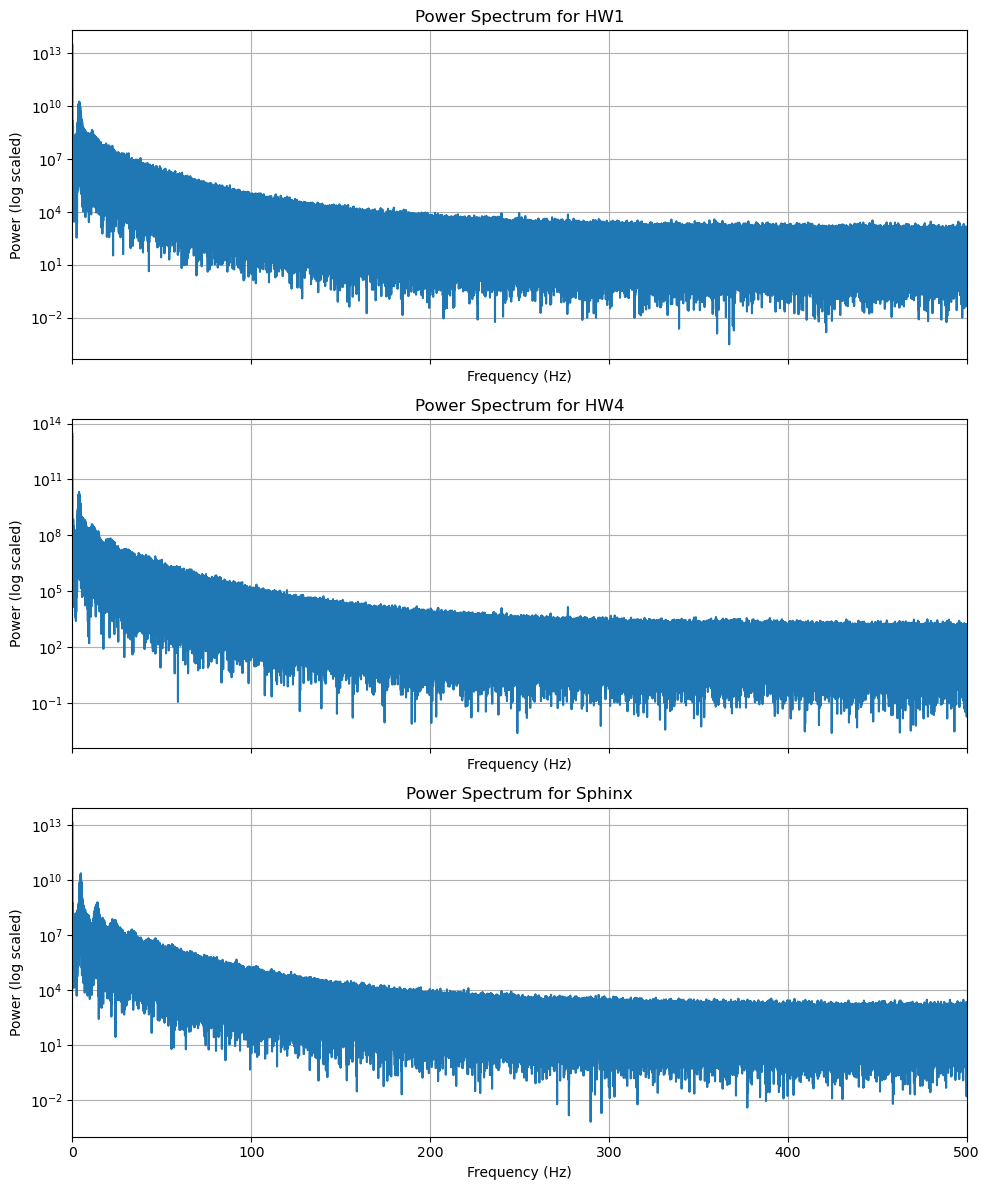

In [9]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 12), sharex=True)

for i, (key, data) in enumerate(breath_dict.items()):
    plot_power_spectrum(data, fs, ax=axs[i])
    axs[i].set_title(f"Power Spectrum for {key}")

plt.tight_layout()
plt.show()


--> Peak at low frequencies (below 100 Hz) and decreasing power with frequency: most of the energy in the lower frequencies

--> noise and artifacts at high frequency

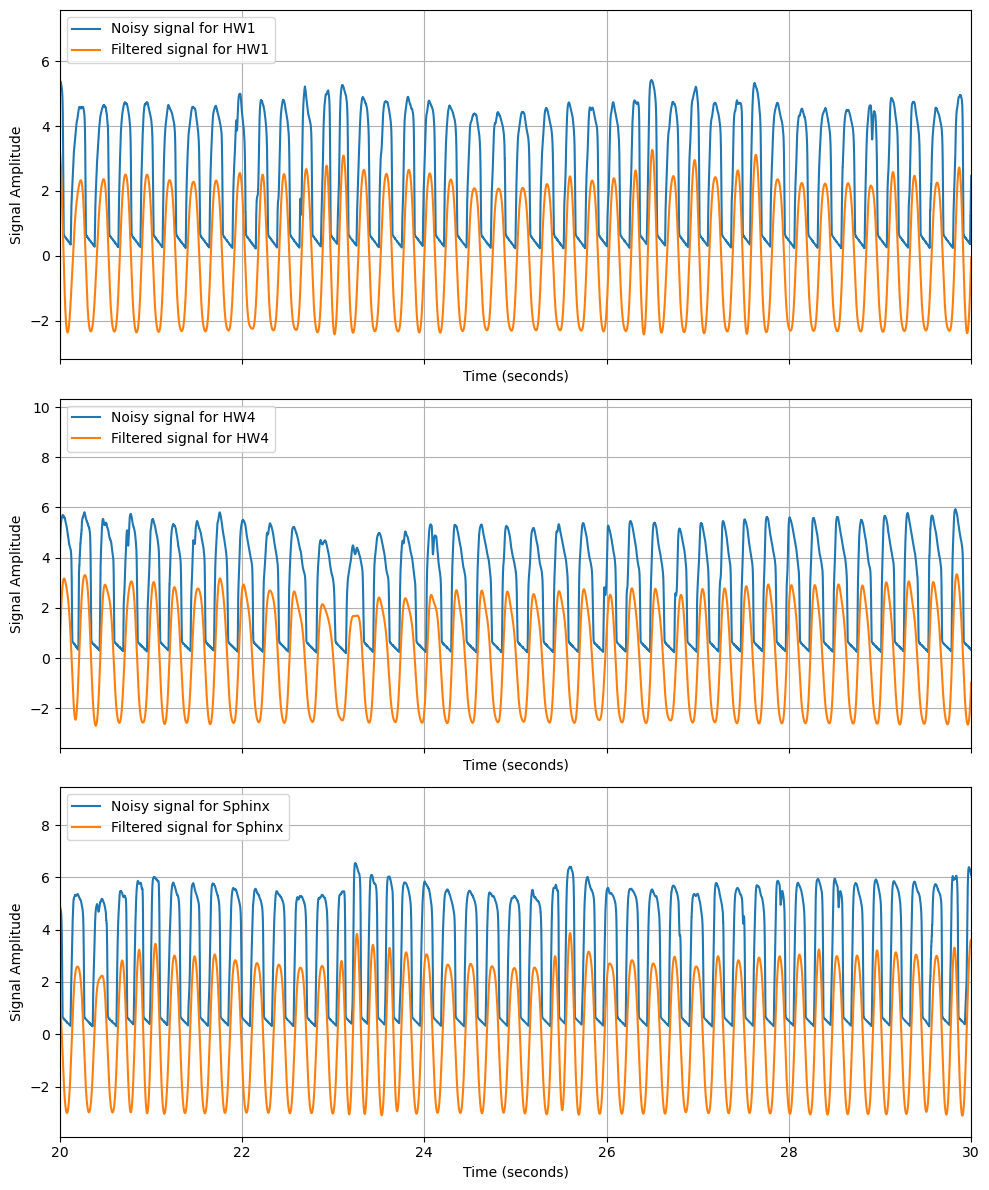

In [10]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 12), sharex=True)

for i, key in enumerate(breath_dict.keys()):
    axs[i].plot(t_breath[i], breath_dict[key], label=f'Noisy signal for {key}')
    axs[i].plot(t_breath[i], breath_filt_dict[key], label=f'Filtered signal for {key}')
    xmin, xmax = 20, 30
    axs[i].set_xlim(xmin, xmax)

    axs[i].set_xlabel('Time (seconds)')
    axs[i].set_ylabel('Signal Amplitude')
    axs[i].grid(True)
    axs[i].legend(loc='upper left')

plt.tight_layout()
plt.show()



mena substract breath signa

### Analysis of Ca imaging

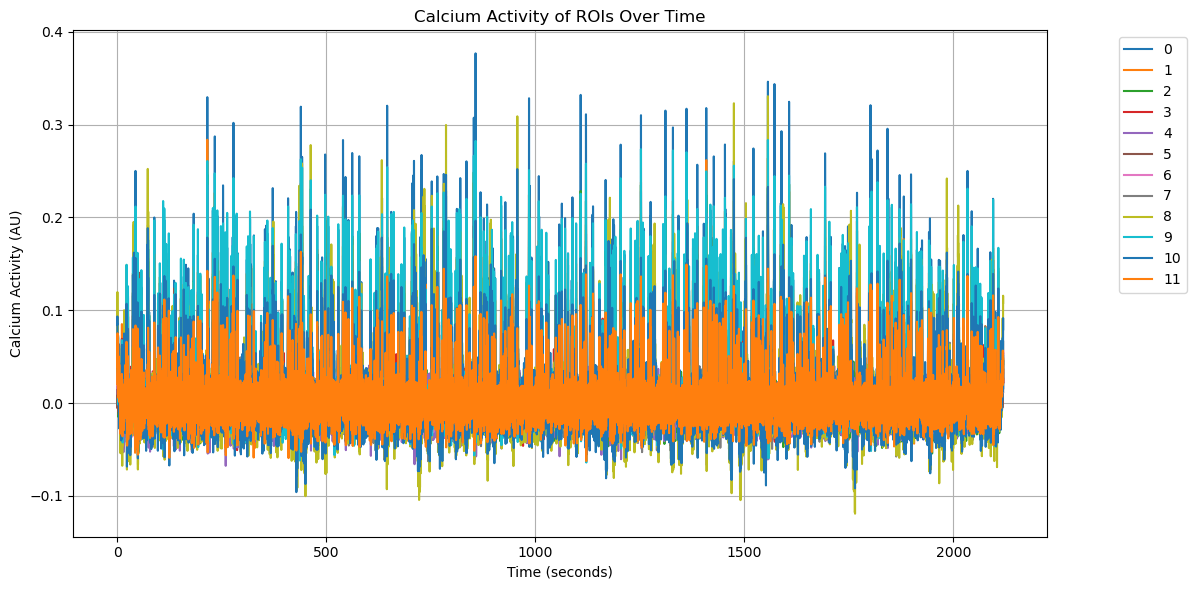

In [9]:
plt.figure(figsize=(12, 6))  

for column in hw1_calcium_ds.columns:
    plt.plot(t_calcium, hw1_calcium_ds[column], label=column) 

plt.xlabel('Time (seconds)')
plt.ylabel('Calcium Activity (AU)') 
plt.title('Calcium Activity of ROIs Over Time')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()  
plt.show()

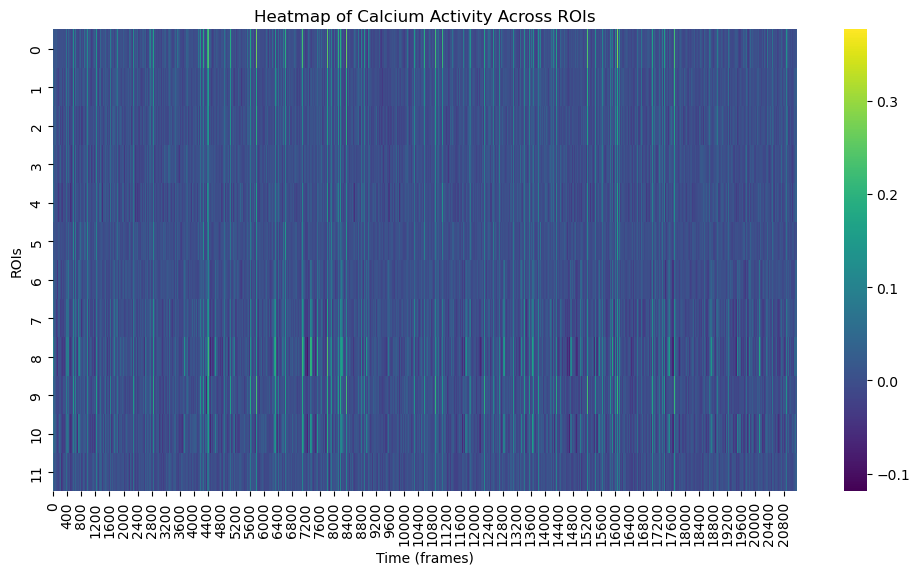

In [10]:
plt.figure(figsize=(12, 6))
sns.heatmap(hw1_calcium_ds.T, cmap='viridis', cbar=True)  # Transpose df so ROIs are on y-axis
plt.xlabel('Time (frames)')
plt.ylabel('ROIs')
plt.title('Heatmap of Calcium Activity Across ROIs')
plt.show()

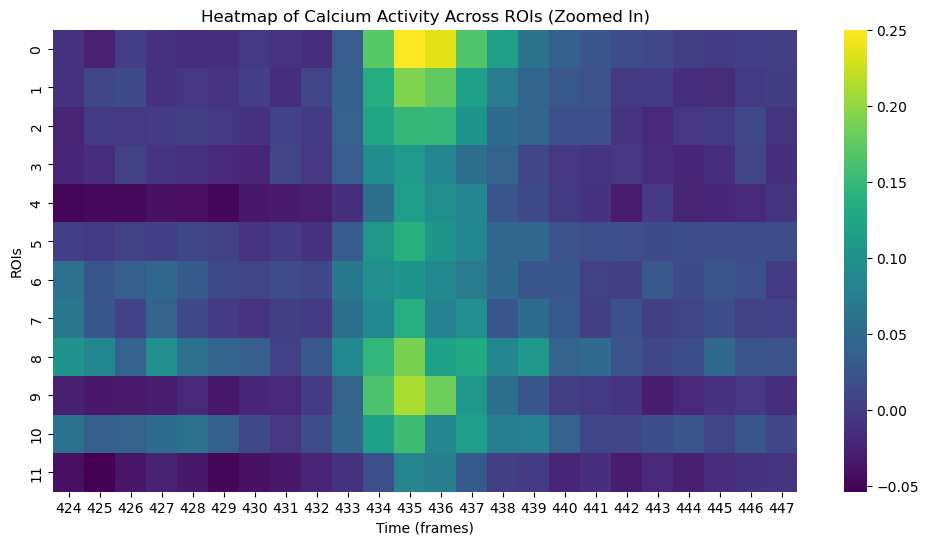

In [11]:
start_frame = 424 
end_frame = 448 

plt.figure(figsize=(12, 6))
sns.heatmap(hw1_calcium_ds.iloc[start_frame:end_frame, :].T, cmap='viridis', cbar=True)  
plt.xlabel('Time (frames)')
plt.ylabel('ROIs')
plt.title('Heatmap of Calcium Activity Across ROIs (Zoomed In)')
plt.show()

### Valve data

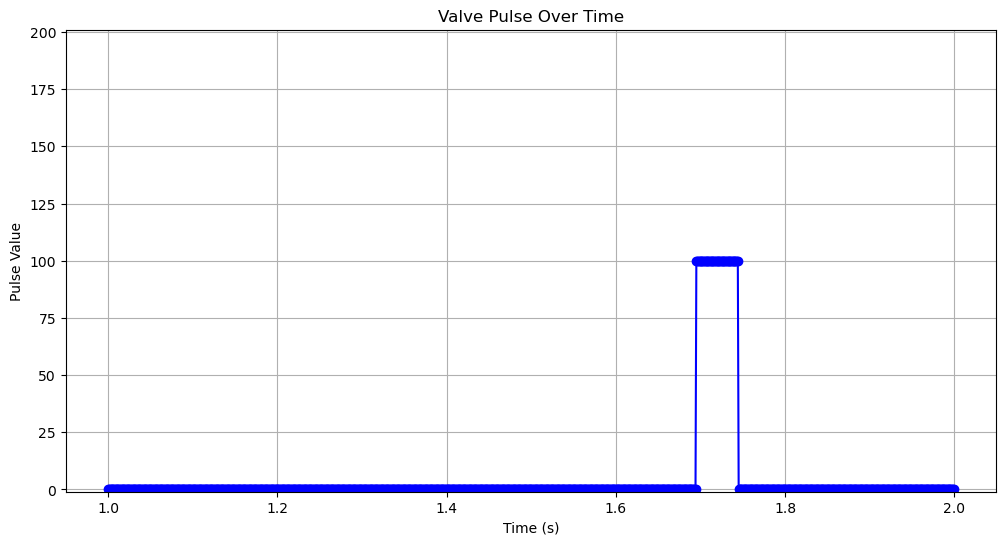

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(t_breath[1000:2000], valve_data[1000:2000], marker='o', linestyle='-', color='b') 
plt.xlabel('Time (s)')
plt.ylabel('Pulse Value')
plt.title('Valve Pulse Over Time')
plt.ylim([valve_data.min() - 1, valve_data.max() + 1]) 
plt.grid()
plt.show()

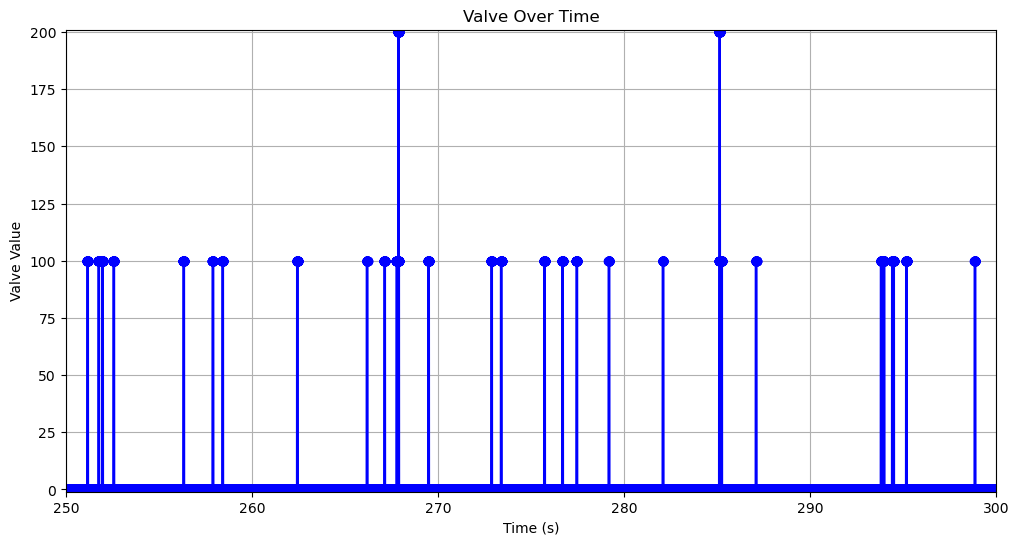

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(t_breath, valve_data, marker='o', linestyle='-', color='b') 
plt.xlabel('Time (s)')
plt.ylabel('Valve Value')
plt.title('Valve Over Time')
plt.xlim([250,300]) 
plt.ylim([valve_data.min() - 1, valve_data.max() + 1]) 
plt.grid()
plt.show()

How is the pulse train generated? 

### Pulse data

kernel applied to valve

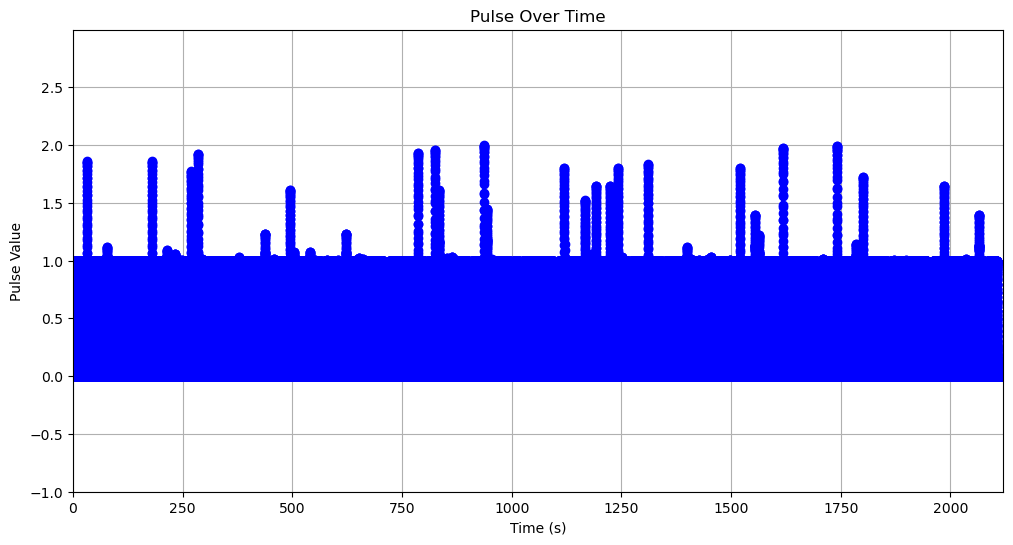

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(t_pulse, pulse_data, marker='o', linestyle='-', color='b') 
plt.xlabel('Time (s)')
plt.ylabel('Pulse Value')
plt.title('Pulse Over Time')
plt.xlim([0, t_breath[-1]]) 
plt.ylim([pulse_data.min() - 1, pulse_data.max() + 1]) 
plt.grid()
plt.show()

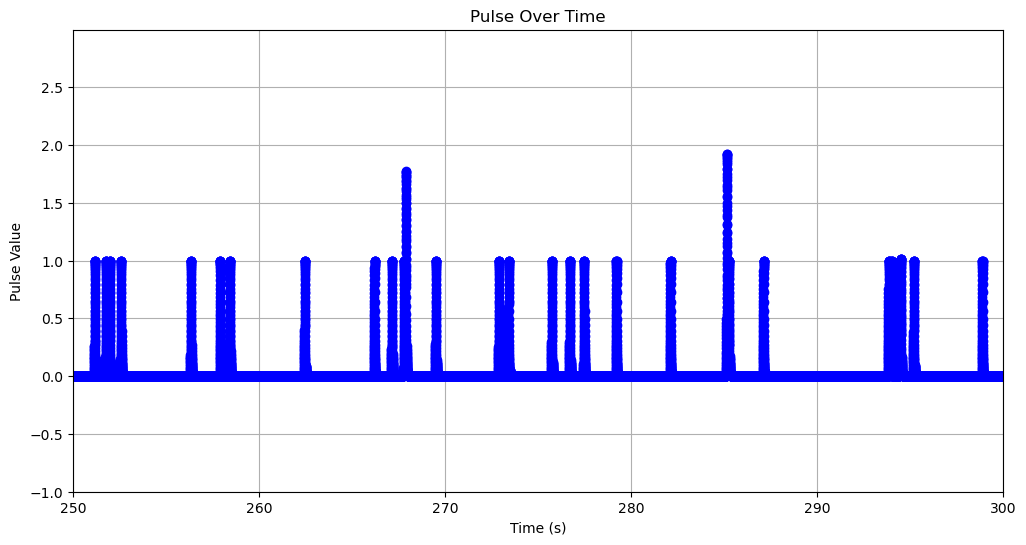

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(t_pulse, pulse_data, marker='o', linestyle='-', color='b') 
plt.xlabel('Time (s)')
plt.ylabel('Pulse Value')
plt.title('Pulse Over Time')
plt.xlim([250,300]) 
plt.ylim([pulse_data.min() - 1, pulse_data.max() + 1]) 
plt.grid()
plt.show()

### Align datasets to a common time base: interpolation of calcium imaging data

C:\Users\blanc\AppData\Local\Temp\ipykernel_31084\3888054808.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\blanc\miniconda3\envs\adaexam\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


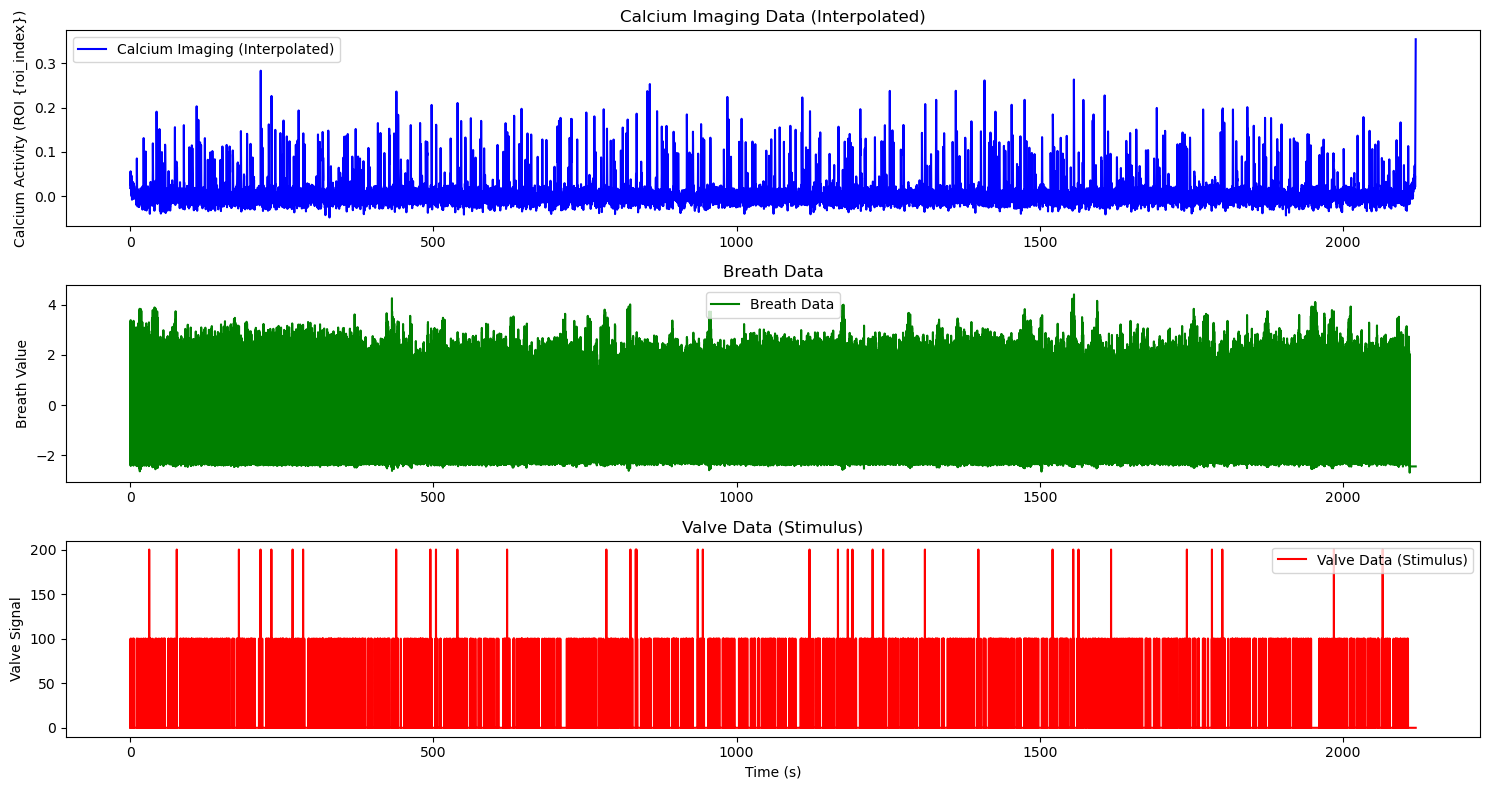

In [18]:
roi_index = 1
calcium_roi_1_interp = hw1_ca_interp_ds.iloc[:, roi_index]  

plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(t_breath, calcium_roi_1_interp, label='Calcium Imaging (Interpolated)', color='b')
plt.title('Calcium Imaging Data (Interpolated)')
plt.ylabel('Calcium Activity (ROI {roi_index})')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_breath, breath_filt, label='Breath Data', color='g')
plt.title('Breath Data')
plt.ylabel('Breath Value')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_breath, valve_data, label='Valve Data (Stimulus)', color='r')
plt.title('Valve Data (Stimulus)')
plt.ylabel('Valve Signal')
plt.xlabel('Time (s)')
plt.legend()

plt.tight_layout()
plt.show()


### Breath, Valve and Calcium Data on one graph

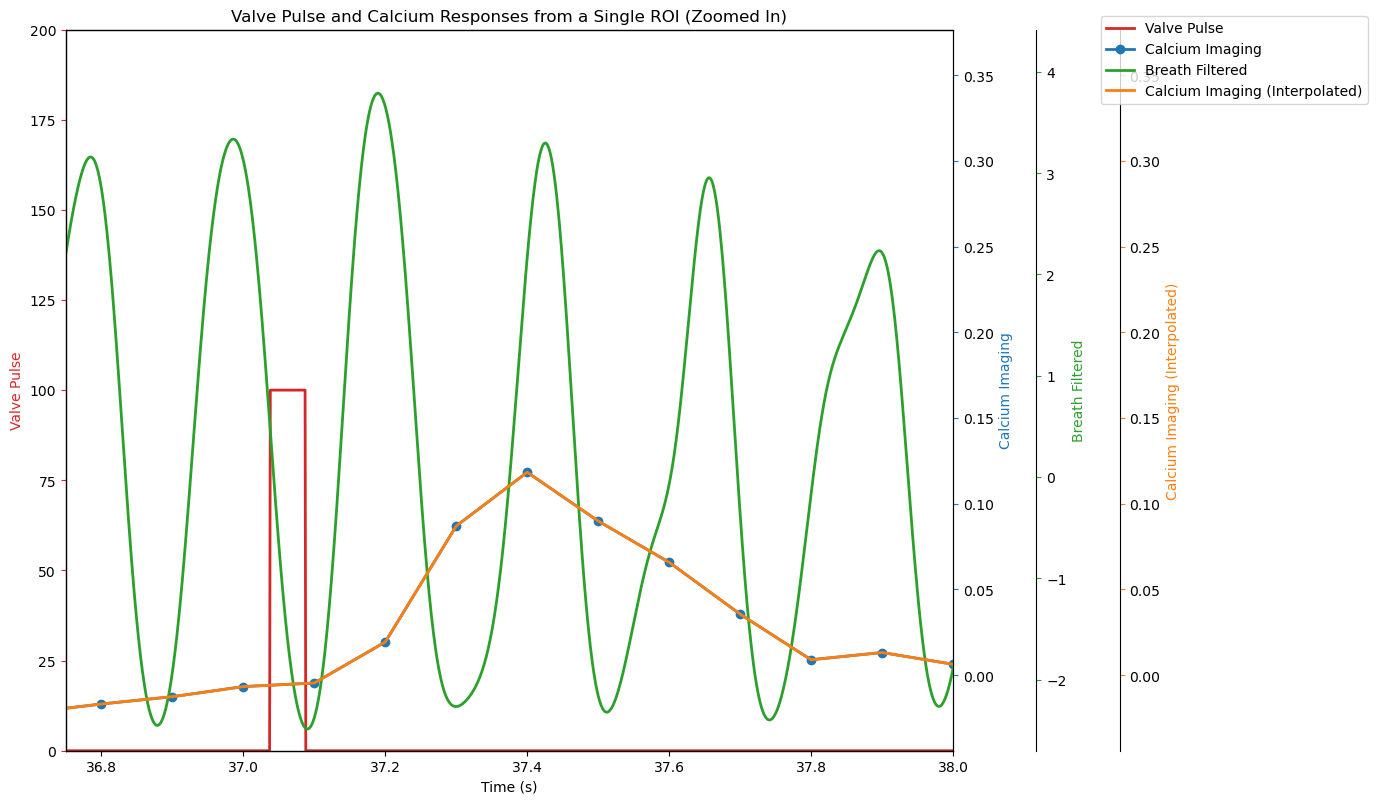

In [19]:
calcium_data = hw1_calcium_ds.iloc[:, 0].to_numpy()
calcium_data_interp = hw1_ca_interp_ds.iloc[:, 0].to_numpy() 

upsampled_calcium_time = np.zeros_like(t_breath)
upsampled_calcium_data = np.zeros_like(t_breath)

calcium_indices = np.searchsorted(t_breath, t_calcium) #Find the closest indices in valve_data_time for each point in calcium_time
upsampled_calcium_time[calcium_indices] = t_calcium
upsampled_calcium_data[calcium_indices] = calcium_data

non_zero_indices = np.where(upsampled_calcium_data != 0)[0]
filtered_calcium_time = upsampled_calcium_time[non_zero_indices]
filtered_calcium_data = upsampled_calcium_data[non_zero_indices]

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Valve Pulse', color='tab:red')
ax1.plot(t_breath, valve_data, color='tab:red', linewidth=2, label='Valve Pulse')
ax1.tick_params(axis='y', color='tab:red')
xmin, xmax = 36.75, 38 
plt.xlim(xmin, xmax)
valve_min, valve_max = np.min(valve_data), np.max(valve_data)
ax1.set_ylim(valve_min, valve_max)

ax2 = ax1.twinx()
calcium_min, calcium_max = np.min(filtered_calcium_data), np.max(filtered_calcium_data)
ax2.set_ylim(calcium_min, calcium_max)
ax2.set_ylabel('Calcium Imaging', color='tab:blue')
ax2.plot(filtered_calcium_time, filtered_calcium_data, color='tab:blue', linewidth=2, marker='o', label='Calcium Imaging')
ax2.tick_params(axis='y', color='tab:blue')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Breath Filtered', color='tab:green')
ax3.plot(t_breath, breath_filt, color='tab:green', linewidth=2, label='Breath Filtered')
ax3.tick_params(axis='y', color='tab:green')
breath_min, breath_max = np.min(breath_filt), np.max(breath_filt)
ax3.set_ylim(breath_min, breath_max)

ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
calcium_min_int, calcium_max_int = np.min(calcium_data_interp), np.max(calcium_data_interp)
ax4.set_ylim(calcium_min_int, calcium_max_int)
ax4.set_ylabel('Calcium Imaging (Interpolated)', color='tab:orange')
ax4.plot(t_breath, calcium_data_interp, color='tab:orange', linewidth=2, label='Calcium Imaging (Interpolated)')
ax4.tick_params(axis='y', color='tab:orange')

fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.title('Valve Pulse and Calcium Responses from a Single ROI (Zoomed In)')
plt.show()


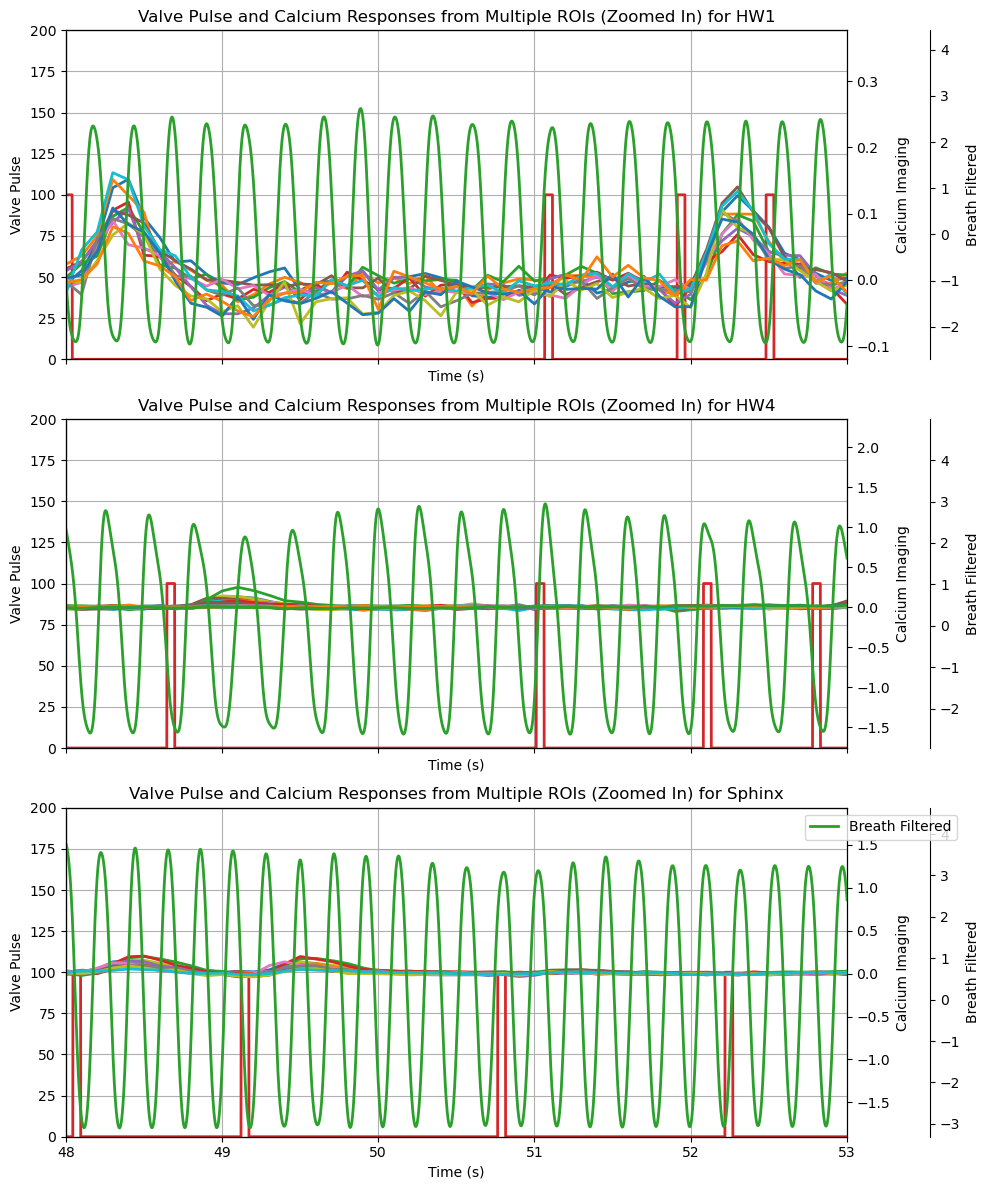

In [11]:
fig, axs = plt.subplots(nrows=len(calcium_dict.keys()), figsize=(10, 12), sharex=True)

for i, key in enumerate(calcium_dict.keys()):
    axs[i].plot(t_breath[i], valve_dict[key], color='tab:red', linewidth=2, label='Valve Pulse')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Valve Pulse')
    axs[i].set_xlim(48, 53)
    valve_min, valve_max = np.min(valve_dict[key]), np.max(valve_dict[key])
    axs[i].set_ylim(valve_min, valve_max)
    axs[i].tick_params(axis='y')

    ax2 = axs[i].twinx()
    calcium_min, calcium_max = np.inf, -np.inf  
    for j in range(len(ca_interp_dict[key].columns)):
        min_val, max_val = np.min(ca_interp_dict[key].iloc[:, j]), np.max(ca_interp_dict[key].iloc[:, j])
        calcium_min = min(calcium_min, min_val)
        calcium_max = max(calcium_max, max_val)
        ax2.plot(t_breath[i], ca_interp_dict[key].iloc[:, j], linewidth=2, label=f'ROI {j+1}')
    ax2.set_ylim(calcium_min, calcium_max)
    ax2.set_ylabel('Calcium Imaging')
    ax2.tick_params(axis='y')

    ax3 = axs[i].twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(t_breath[i], breath_filt_dict[key], color='tab:green', linewidth=2, label='Breath Filtered')
    breath_min, breath_max = np.min(breath_filt_dict[key]), np.max(breath_filt_dict[key])
    ax3.set_ylim(breath_min, breath_max)
    ax3.set_ylabel('Breath Filtered')
    ax3.tick_params(axis='y')

    axs[i].set_title(f'Valve Pulse and Calcium Responses from Multiple ROIs (Zoomed In) for {key}')
    axs[i].grid(True)

fig.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()


### Hilbert Decomposition

In [31]:
analytic_signal = []
amplitude_env = []
instant_phase = []
instant_freq = []

for i, key in enumerate(breath_filt_dict.keys()):
    analytic_signal.append(hilbert(breath_filt_dict[key]))
    amplitude_env.append(np.abs(analytic_signal[i]))
    instant_phase.append(np.angle(analytic_signal[i]))
    instant_freq.append(np.diff(instant_phase[i]) / (2.0*np.pi) * fs_breath)

analytic_signal_dict = dict(zip(animals, analytic_signal))
amplitude_env_dict = dict(zip(animals, amplitude_env))
instant_phase_dict = dict(zip(animals, instant_phase))
instant_freq_dict = dict(zip(animals, instant_freq))


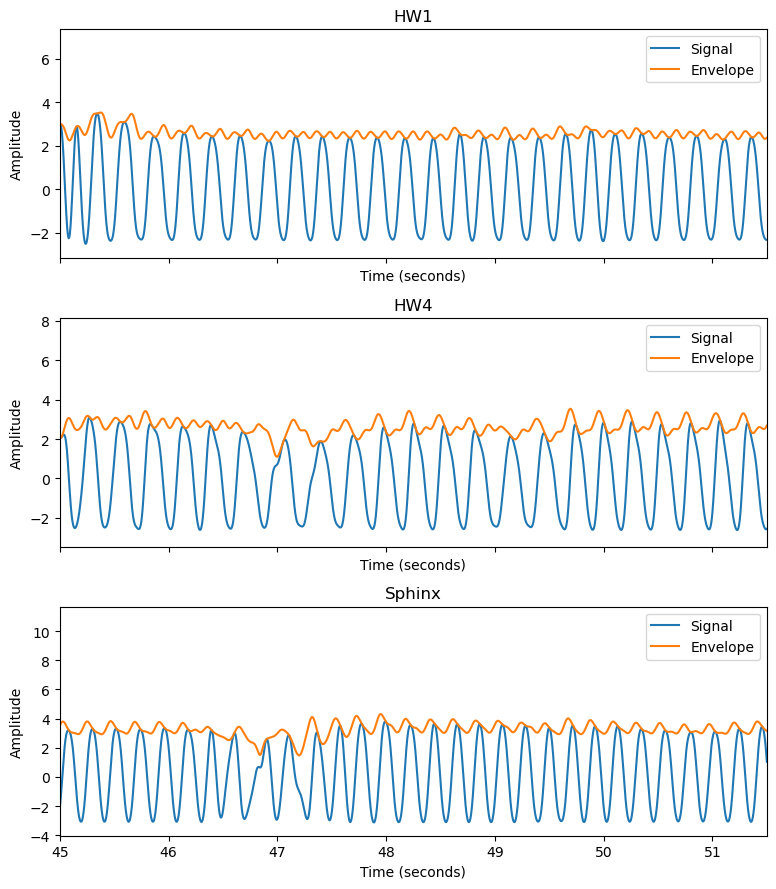

In [13]:
fig, axs = plt.subplots(nrows=3, figsize=(8, 9), sharex=True)

for i, key in enumerate(breath_dict.keys()):

    axs[i].plot(t_breath[i], breath_filt_dict[key], label='Signal')
    axs[i].plot(t_breath[i], amplitude_env_dict[key], label='Envelope')

    axs[i].set_xlabel("Time (seconds)")
    axs[i].set_ylabel("Amplitude")

    axs[i].legend()

    xmin, xmax = 45, 51.5
    axs[i].set_xlim(xmin, xmax)

    axs[i].set_title(f'{key}')

plt.tight_layout()
plt.show()


#### Align Breath Cycle and Breath Phase

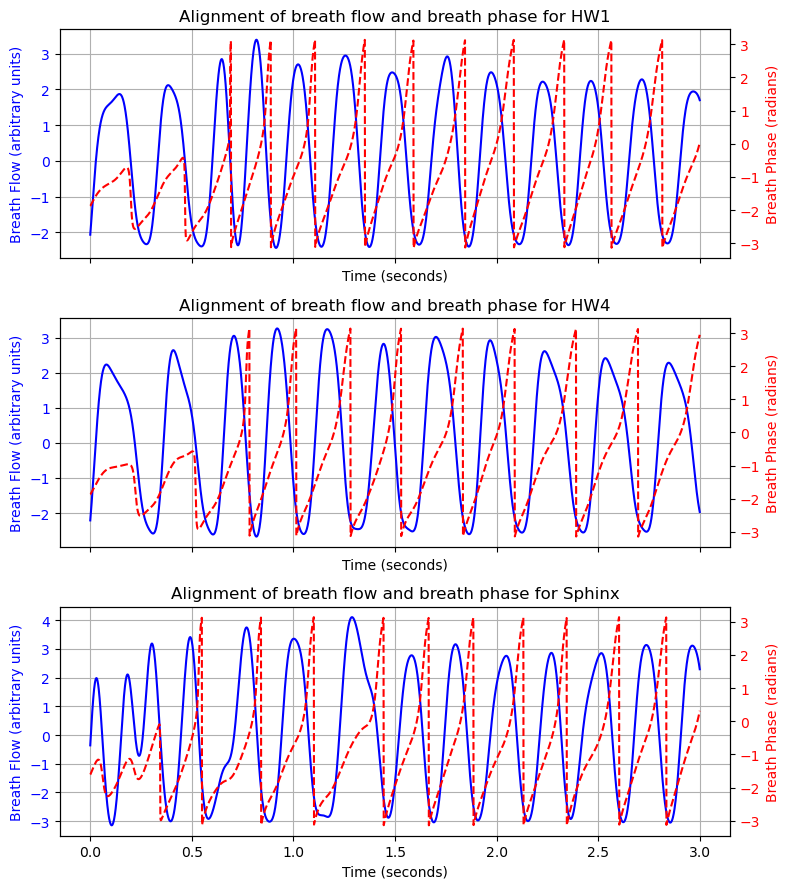

In [14]:
fig, axs = plt.subplots(nrows=3, figsize=(8, 9), sharex=True)

for i, key in enumerate(breath_dict.keys()):

    axs[i].plot(t_breath[i][0:3000], breath_filt[i][0:3000], label='Breath Flow', color='blue')
    axs[i].set_xlabel('Time (seconds)')
    axs[i].set_ylabel('Breath Flow (arbitrary units)', color='blue')
    axs[i].tick_params(axis='y', labelcolor='blue')

    ax2 = axs[i].twinx()
    ax2.plot(t_breath[i][0:3000], instant_phase_dict[key][0:3000], label='Breath Phase', color='red', linestyle='--')
    ax2.set_ylabel('Breath Phase (radians)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    axs[i].set_title(f'Alignment of breath flow and breath phase for {key}')
    axs[i].grid(True)

fig.tight_layout()
plt.show()

- Exhalation: -𝜋 to 0 [2𝜋]
- Inhalation: 0 to 𝜋 [2𝜋]

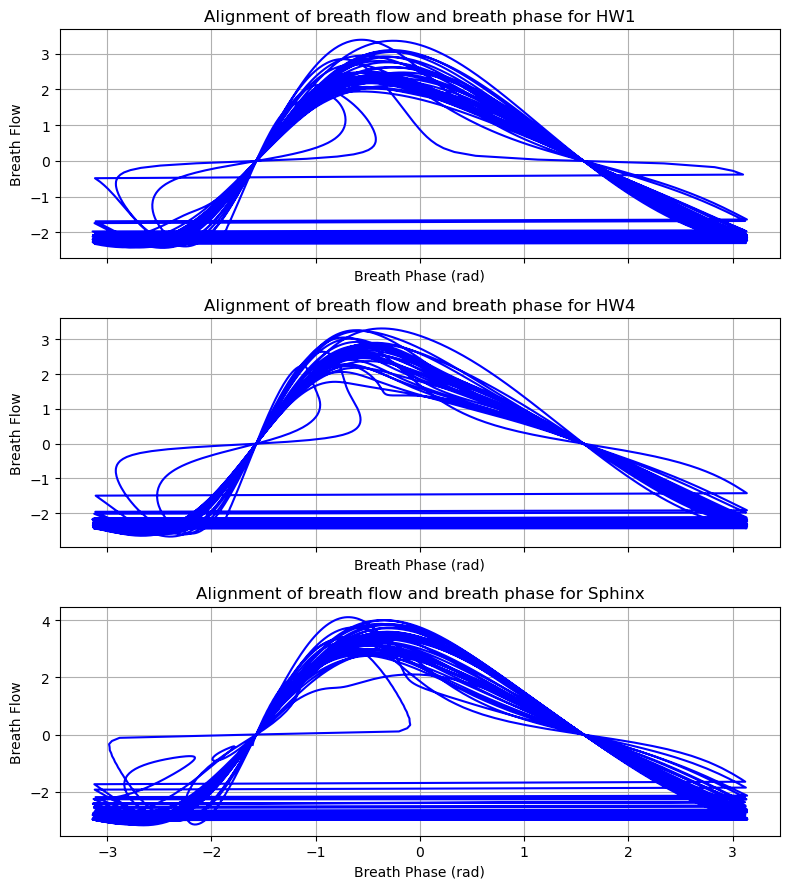

In [15]:
fig, axs = plt.subplots(nrows=3, figsize=(8, 9), sharex=True)

for i, key in enumerate(breath_dict.keys()):

    axs[i].plot(instant_phase_dict[key][0:10000], breath_filt[i][0:10000], label='Breath Flow', color='blue')
    axs[i].set_xlabel('Breath Phase (rad)')
    axs[i].set_ylabel('Breath Flow')
    axs[i].tick_params(axis='y')

    axs[i].set_title(f'Alignment of breath flow and breath phase for {key}')
    axs[i].grid(True)

fig.tight_layout()
plt.show()

### Phase with respect to Ca imaging

bin the derivatie of the sniffing signal
plot the response as a function of the derivaitve

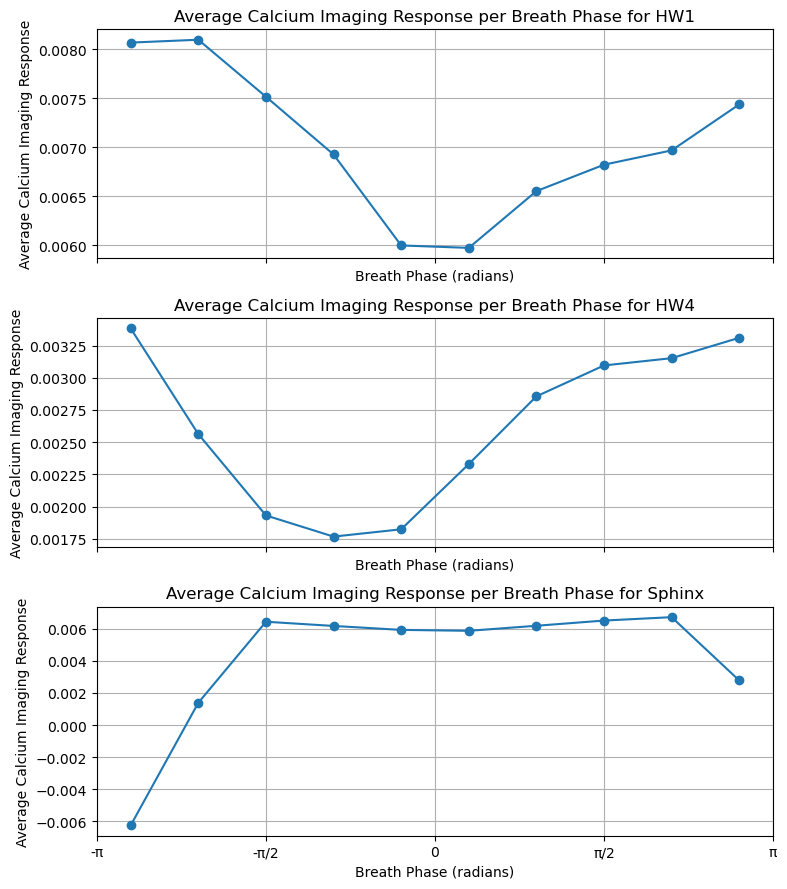

In [16]:
fig, axs = plt.subplots(nrows=3, figsize=(8, 9), sharex=True)

# Bin the breath phase data
num_bins = 10  
phase_bins = np.linspace(-np.pi, np.pi, num_bins + 1)

for i, key in enumerate(breath_dict.keys()):

    average_calcium_response = ca_interp_dict[key].mean(axis=1)  # Row-wise mean
    avg_calcium_per_phase = np.zeros(num_bins)

    # Mean calcium response for each phase bin
    for j in range(num_bins):
        in_bin = (instant_phase_dict[key] >= phase_bins[j]) & (instant_phase_dict[key] < phase_bins[j + 1])
        
        if np.any(in_bin):  
            avg_calcium_per_phase[j] = average_calcium_response[in_bin].mean()

    phase_bin_centers = (phase_bins[:-1] + phase_bins[1:]) / 2

    axs[i].plot(phase_bin_centers, avg_calcium_per_phase, marker='o', linestyle='-')
    axs[i].set_xlabel("Breath Phase (radians)")
    axs[i].set_ylabel("Average Calcium Imaging Response")
    axs[i].set_xticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
    axs[i].set_xticklabels(['-π', '-π/2', '0', 'π/2', 'π'])

    axs[i].set_title(f'Average Calcium Imaging Response per Breath Phase for {key}')
    axs[i].grid()


fig.tight_layout()
plt.show()

- Phase Peaks: sharp increase in the average calcium response right after 𝜋/2 --> mmay correspond to a specific phase of the breathing cycle
Correlation between ca response and a particular part of either inhalation (based on the graph phase abd breath rhythm as a function of time plotted before)
- Drop after Peak: then gradual decline in the calcium response, with a low at 3𝜋/2
--> calcium response less responsive during this part of the cycle

--> periodic sensitivity to the breath phase, with calcium response not uniform across the cycle

Hypotheses Based on the Observations
- Phase-locked Neuronal Activity: neural responsiveness fluctuates with the breath cycle
- Response to Specific Breathing Events: olfactory neurons may be tuned to detect parts of the cycle more intensely

#### Phas

C:\Users\blanc\AppData\Local\Temp\ipykernel_28656\3428094824.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])


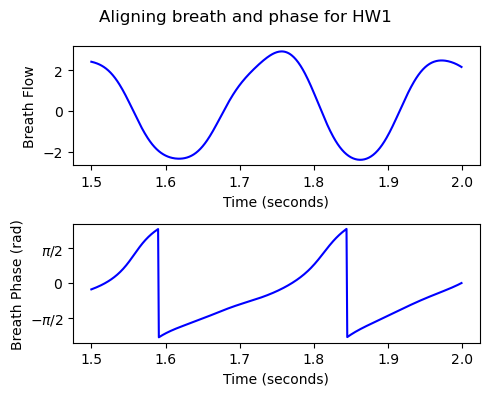

C:\Users\blanc\AppData\Local\Temp\ipykernel_28656\3428094824.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])


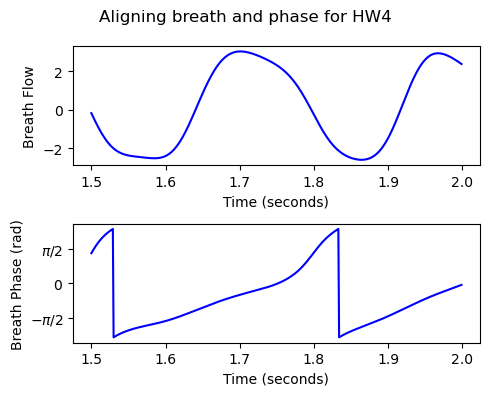

C:\Users\blanc\AppData\Local\Temp\ipykernel_28656\3428094824.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])


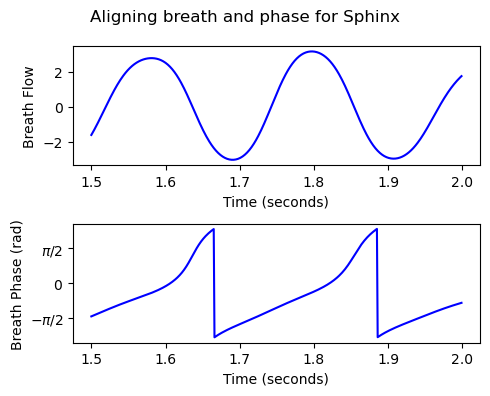

In [17]:
def plot_mean_intensity_per_bin(instantaneous_phase, ca_df, breath_flow, t_breath, animal):
    mean_intensity_per_bin = pd.DataFrame(0, index=range(num_bins), columns=ca_df.columns)

    for i in range(num_bins):
        in_bin = (instantaneous_phase >= phase_bins[i]) & (instantaneous_phase < phase_bins[i + 1])
        mean_intensity_per_bin.iloc[i, :] = ca_df[in_bin].mean()

    fig, (ax2, ax3) = plt.subplots(nrows=2, figsize=(5, 4), gridspec_kw={'height_ratios': [1, 1]})

    """norm = mcolors.Normalize(vmin=mean_intensity_per_bin.min().min(), vmax=mean_intensity_per_bin.max().max())

    cax = ax1.imshow(mean_intensity_per_bin.T, aspect='auto', origin='lower', cmap='viridis',
                    extent=[-np.pi, np.pi, 0, ca_df.shape[1]], norm=norm)
    ax1.set_xticks(np.linspace(-np.pi, np.pi, 5))
    ax1.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
    ax1.set_yticks(np.arange(ca_df.shape[1]))
    ax1.set_yticklabels([f'ROI {i+1}' for i in range(ca_df.shape[1])])
    ax1.set_xlabel('Breath Phase (radians)')
    ax1.set_ylabel('ROIs')

    cbar = fig.colorbar(cax, ax=ax1, label='Calcium Imaging Intensity', extend='both', ticks=np.linspace(norm.vmin, norm.vmax, 10))
    cbar.ax.tick_params(labelsize=8)"""

    # Plot breath flow
    ax2.plot(t_breath[1500:2000], breath_flow[1500:2000], label='Breath Flow', color='blue')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Breath Flow')

    # Plot breath phase
    ax3.plot(t_breath[1500:2000], instantaneous_phase[1500:2000], label='Breath Phase', color='blue')
    ax3.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Breath Phase (rad)')

    fig.suptitle(f"Aligning breath and phase for {animal}")

    plt.tight_layout()
    plt.show()


plot_mean_intensity_per_bin(instantaneous_phase=instant_phase_dict['HW1'], ca_df=ca_interp_dict['HW1'], breath_flow=breath_filt_dict['HW1'], t_breath=t_breath[0], animal="HW1")
plot_mean_intensity_per_bin(instantaneous_phase=instant_phase_dict['HW4'], ca_df=ca_interp_dict['HW4'], breath_flow=breath_filt_dict['HW4'], t_breath=t_breath[1], animal="HW4")
plot_mean_intensity_per_bin(instantaneous_phase=instant_phase_dict['Sphinx'], ca_df=ca_interp_dict['Sphinx'], breath_flow=breath_filt_dict['Sphinx'], t_breath=t_breath[2], animal="Sphinx")


-> Most of the calcium signals are detected in the bin from -pi to pi/2 or from pi/2 to pi
-> ROIs show variability in intensity --> some ROIs respond more strongly during specific phases of the breath cycle

#### Avg Response to Pulse Onsets by Phase

In [9]:
def mean_first_n(series, n):
    return series.head(n).mean()

def mean_last_n(series, n):
    return series.tail(n).mean()

In [10]:
calcium_pulse = []

for i, key in enumerate(ca_interp_dict.keys()):

    ca_pulse = pd.DataFrame({
        'time': t_breath[i], 
        'phase': instant_phase_dict[key], 
        'valve': valve_dict[key], 
        'avg_roi_ca': ca_interp_dict[key].mean(axis=1).to_numpy()}, 
        columns=['time', 'phase', 'valve', 'avg_roi_ca'])
    
    valve_nonzero = ca_pulse['valve'] != 0.0 #boolean mask
    # find where valve turns on and off
    pulse_start = (valve_nonzero & ~valve_nonzero.shift(fill_value=False)).astype(int) # 1 if the index is where the pulse started
    pulse_end = (~valve_nonzero & valve_nonzero.shift(fill_value=False)).astype(int)

    start_indexes = pulse_start[pulse_start == 1].index.to_numpy()
    end_indexes = pulse_end[pulse_end ==1].index.to_numpy()

    # assign an ID to each pulse
    ca_pulse['pulse_id'] = np.nan
    for pulse_idx, (start, end) in enumerate(zip(start_indexes, end_indexes), start=1):
        ca_pulse.loc[start:end, 'pulse_id'] = pulse_idx

    # the same ID should be assigned also to the next 600 rows (600 ms time window around the pulse)
    for end in end_indexes:
        ca_pulse.loc[end+1:end+601, 'pulse_id'] = ca_pulse.loc[end, 'pulse_id']

    pulse_data = ca_pulse.dropna(subset=['pulse_id'])

    result = (
        pulse_data.groupby('pulse_id')
        .agg(
            pulse_id = ('pulse_id', 'first'),
            time= ('time', 'first'),
            #phase=('phase', lambda x: mean_first_n(x, 50)),  # Mean of first 50 rows for phase (during the pulse)
            phase = ('phase', 'first'),
            valve= ('valve', lambda x: x[x != 0].iloc[0] if not x[x != 0].empty else np.nan),
            avg_roi_ca= ('avg_roi_ca', lambda x: mean_last_n(x, 500))  # Mean of last 500 rows for avg_roi_ca (taking into account delay in the ca response to a pulse)
        )
        .reset_index(drop=True)
    )
    calcium_pulse.append(result)

calcium_pulse_dict = dict(zip(animals, calcium_pulse))

print(calcium_pulse_dict['HW1'].head())

   pulse_id   time     phase  valve  avg_roi_ca
0       1.0  0.510 -2.562617  100.0    0.039121
1       2.0  1.695 -1.310640  100.0    0.031376
2       3.0  4.101 -2.235218  100.0    0.013473
3       4.0  5.501 -1.376469  100.0    0.008458
4       5.0  6.153  3.120491  100.0    0.012456


kernel:apply a filter that is the avg of the ca respose 

estimate the filter based on the calcium response after the lag 

paired pulse reponses


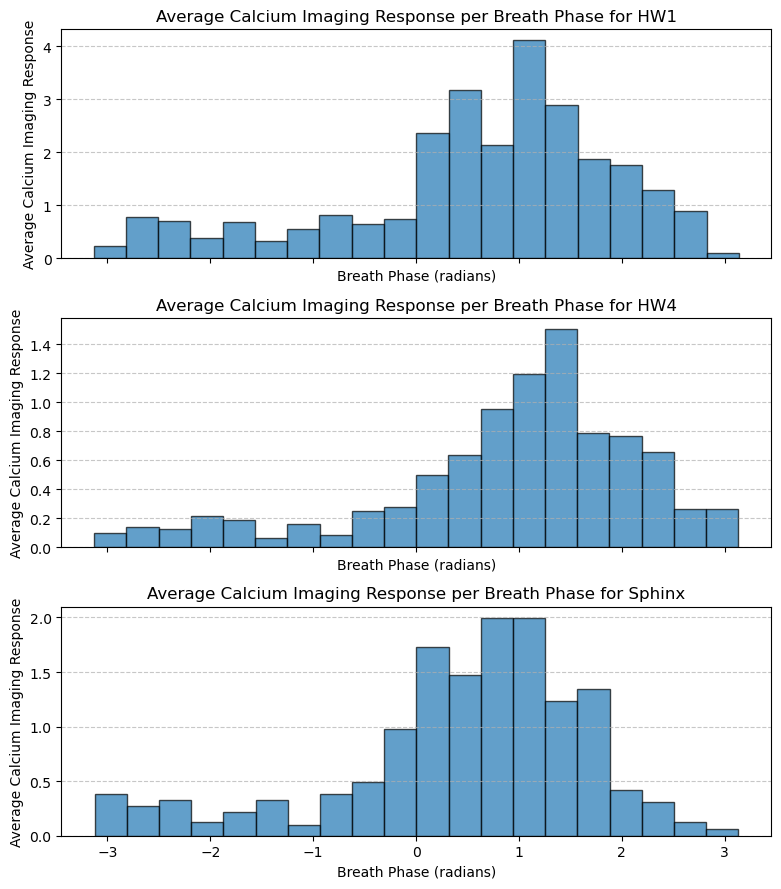

In [20]:
fig, axs = plt.subplots(nrows=3, figsize=(8, 9), sharex=True)

for i, key in enumerate(calcium_pulse_dict.keys()):

    ca_pulse = calcium_pulse_dict[key].sort_values(by='phase', ascending=True).reset_index(drop=True)

    axs[i].hist(ca_pulse['phase'], bins=20, weights=ca_pulse['avg_roi_ca'], edgecolor='black', alpha=0.7)

    axs[i].set_xlabel("Breath Phase (radians)")
    axs[i].set_ylabel("Average Calcium Imaging Response")
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
    axs[i].set_title(f'Average Calcium Imaging Response per Breath Phase for {key}')

fig.tight_layout()
plt.show()

--> When the pulse arrives in [0,pi] phase interval, there seem to be an enhanced calcium response

look at the preceding starting from the end,
row(n)-row(n-1)
row(n)-row(n-2)
...
row(n)-row(n-m)
iterate over the rows until row(n)-row(n-m) > threshold (relative time threshold)

--> store in a df:
pulse id   relative time
2000        -0.5
2000        -1 

How to link this to ca response? 
bc id the pulses are randomly generated

or instead of looking at pulse id, do a find_peak and detect the ca peaks and look at the preceding ca peaks 


#### Sniff Kernel (replicating Joe's analysis)

In [11]:
def max_interval(series, start_index, end_index):
    return series.iloc[start_index:end_index].max()

In [12]:
calcium_pulse = []

for i, key in enumerate(ca_interp_dict.keys()):

    ca_pulse = pd.DataFrame({
        'time': t_breath[i], 
        'phase': instant_phase_dict[key], 
        'valve': valve_dict[key], 
        'avg_roi_ca': ca_interp_dict[key].mean(axis=1).to_numpy()}, 
        columns=['time', 'phase', 'valve', 'avg_roi_ca'])
    
    valve_nonzero = ca_pulse['valve'] != 0.0 #boolean mask
    # find where valve turns on and off
    pulse_start = (valve_nonzero & ~valve_nonzero.shift(fill_value=False)).astype(int) # 1 if the index is where the pulse started
    pulse_end = (~valve_nonzero & valve_nonzero.shift(fill_value=False)).astype(int)

    start_indexes = pulse_start[pulse_start == 1].index.to_numpy()
    end_indexes = pulse_end[pulse_end ==1].index.to_numpy()

    # assign an ID to each pulse
    ca_pulse['pulse_id'] = np.nan
    for pulse_idx, (start, end) in enumerate(zip(start_indexes, end_indexes), start=1):
        ca_pulse.loc[start:end, 'pulse_id'] = pulse_idx

    # the same ID should be assigned also to the next 900 rows (900 ms time window around the pulse)
    for end in end_indexes:
        ca_pulse.loc[end+1:end+901, 'pulse_id'] = ca_pulse.loc[end, 'pulse_id']

    pulse_data = ca_pulse.dropna(subset=['pulse_id'])

    result = (
        pulse_data.groupby('pulse_id')
        .agg(
            pulse_id = ('pulse_id', 'first'),
            time= ('time', 'first'),
            #phase=('phase', lambda x: mean_first_n(x, 50)),  # Mean of first 50 rows for phase (during the pulse)
            phase = ('phase', 'first'),
            valve= ('valve', lambda x: x[x != 0].iloc[0] if not x[x != 0].empty else np.nan),
            amp_ca= ('avg_roi_ca', lambda x: (max_interval(x, 300, 500) - abs(max_interval(x, 100, 200))))  # Mean of last 500 rows for avg_roi_ca (taking into account delay in the ca response to a pulse)
        )
        .reset_index(drop=True)
    )
    calcium_pulse.append(result)

calcium_pulse_dict = dict(zip(animals, calcium_pulse))

print(calcium_pulse_dict['HW1'].head())

   pulse_id    time     phase  valve    amp_ca
0       1.0   0.510 -2.562617  100.0 -0.007733
1       2.0   1.695 -1.310640  100.0 -0.004726
2       3.0   4.101 -2.235218  100.0 -0.008721
3       4.0   5.501 -1.376469  100.0  0.000901
4       6.0  10.616 -0.033270  100.0  0.041400


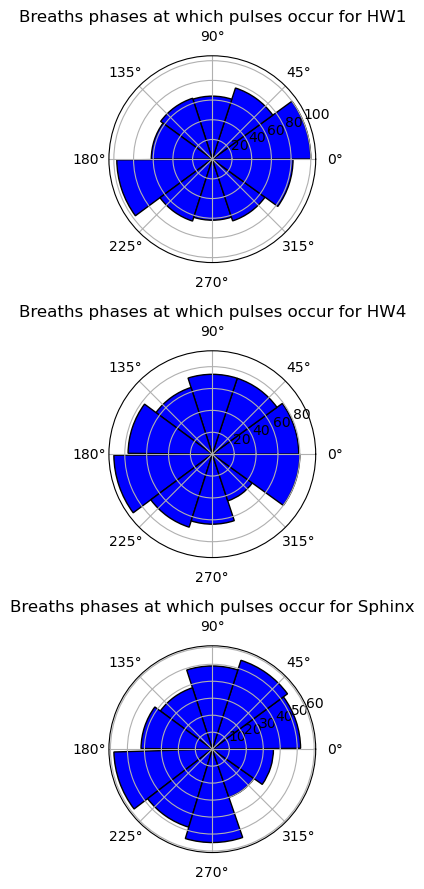

In [23]:
fig, axs = plt.subplots(subplot_kw={'projection':'polar'},nrows=3, figsize=(8, 9), sharex=True)

for i, key in enumerate(calcium_pulse_dict.keys()):

    axs[i].hist(calcium_pulse_dict[key]['phase'], color='blue', edgecolor='black')
    axs[i].set_title(f'Breaths phases at which pulses occur for {key}')

fig.tight_layout()
plt.show()

#### Creating the sniff kernels

Compute a sniff-phase-dependent kernel that characterizes the relationship between the phase sniff phase and calcium activity peaks around pulses

Reformulation: kernel describes how the neural activity (as measured by calcium response) varies as a function of the sniff phase at which an odor pulse is delivered

In [13]:
n_bins = 20
bin_edges = np.linspace(-np.pi, np.pi, n_bins + 1)

kernels = []

for i, key in enumerate(calcium_pulse_dict.keys()): 
    
    sniff_kernel = np.zeros(n_bins)

    bin_indices = np.digitize(calcium_pulse_dict[key]['phase'], bin_edges) - 1

    for j in range(n_bins):
        indices_in_bin = np.where(bin_indices == j)[0] #indices of phases that fall into bin j
        # a 1D array

        if len(indices_in_bin) > 0:
            # sniff kernel: the avg of the ca amplitude of all the responses to pulses occuring around the same breath phase
            sniff_kernel[j] = np.nanmean(calcium_pulse_dict[key]['amp_ca'][indices_in_bin])

    kernels.append(sniff_kernel)

sniff_kernel_dict = dict(zip(animals, kernels))

In [14]:
def plot_sniff_kernel_line(sniff_kernel, n_bins=20):
    # Define phase centers for each bin
    phase_centers = np.linspace(-np.pi, np.pi, n_bins, endpoint=False) + (2 * np.pi / n_bins) / 2

    plt.figure(figsize=(5, 3))
    plt.plot(phase_centers, sniff_kernel, marker='o', linestyle='-', color='b')
    plt.title('Sniff Kernel - Calcium Response vs Sniff Phase')
    plt.xlabel('Sniff Phase (radians)')
    plt.ylabel('Average Calcium Amplitude')
    plt.xticks(np.linspace(-np.pi, np.pi, 9),
               ['π', '-3π/4', '-π/2', '-π/4', '0', 'π/4', 'π/2', '3π/4', 'π'])
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
def plot_sniff_kernel_bar(sniff_kernel, n_bins=20):
    # Define phase edges and centers
    phase_edges = np.linspace(-np.pi, np.pi, n_bins + 1)
    phase_centers = phase_edges[:-1] + np.diff(phase_edges)/2

    width = 2 * np.pi / n_bins * 0.9  # Adjust width for aesthetics

    plt.figure(figsize=(5, 3))
    plt.bar(phase_centers, sniff_kernel, width=width, align='center', color='skyblue', edgecolor='k')
    plt.title('Sniff Kernel - Calcium Response vs Sniff Phase')
    plt.xlabel('Sniff Phase (radians)')
    plt.ylabel('Average Calcium Amplitude')
    plt.xticks(np.linspace(-np.pi, np.pi, 9),
               [r'$\pi$', r'$-3\pi/4$', r'$-\pi/2$', r'$-\pi/4$', r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

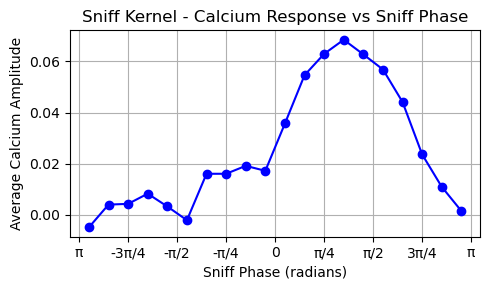

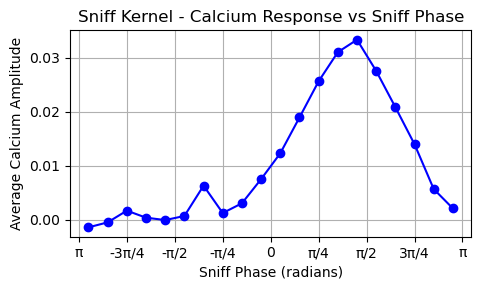

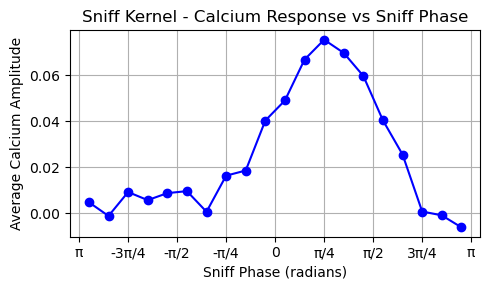

In [16]:
for i, key in enumerate(sniff_kernel_dict.keys()):
    plot_sniff_kernel_line(sniff_kernel_dict[key])

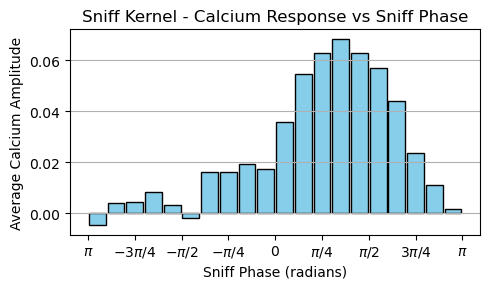

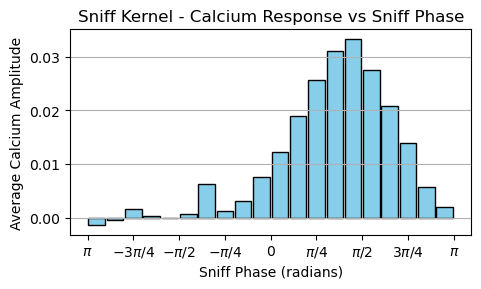

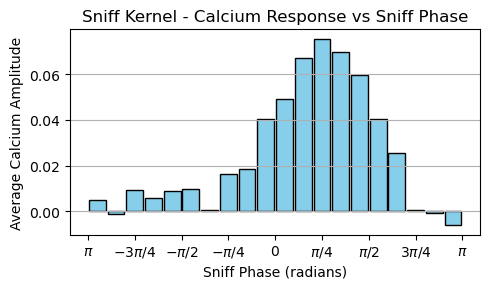

In [17]:
for i, key in enumerate(sniff_kernel_dict.keys()):
    plot_sniff_kernel_bar(sniff_kernel_dict[key])

#### Reverse-correlation estimate of linear filter across lag and phase


The goal is to study the relationship between the stimulus and the response (captured by the correlation coefficient) at different time lags to analyze how past or future stimulus events relate to the calcium response

Reverse correlation: Average integral of the product of stimulus s(t − τ) and response r(t) as a function of time-shift τ --> Measures the effect of earlier stimuli on later responses

we can view reverse correlation as estimating an approximate gradient of the response function of a neuron.

In [32]:
def reverse_correlation_2d(pulse, ca, breath_phase, max_lag, n_phase_bins):
    """
    Computes a 2D reverse correlation between a pulse stimulus and calcium response,
    taking into account the breathing phase.
    """
    max_lag = min(max_lag, len(pulse) - 1)
    
    phase_bins = np.linspace(-np.pi, np.pi, n_phase_bins + 1)
    phase_indices = np.digitize(breath_phase, phase_bins) - 1
    
    rc_2d = np.zeros((max_lag, n_phase_bins))
    
    for lag in range(max_lag):
        products = ca[lag+1:] * pulse[:-(lag+1)] # Multiply shifted calcium response with pulse signal
        np.add.at(rc_2d[lag], phase_indices[lag+1:], products) # Accumulate products into appropriate phase bins
    
    # Normalize by total number of pulses
    pulse_sum = np.sum(pulse)
    if pulse_sum > 0:
        rc_2d /= pulse_sum
    
    return rc_2d

In [10]:
"""def reverse_correlation_2d(pulse, ca, breath_phase, max_lag, n_phase_bins, stride):
    
    Computes a 2D reverse correlation between a pulse stimulus and calcium response,
    taking into account the breathing phase.
    
    max_lag = min(max_lag, len(pulse) - 1)
    
    phase_bins = np.linspace(-np.pi, np.pi, n_phase_bins + 1)
    phase_indices = np.digitize(breath_phase, phase_bins) - 1
    
    rc_2d = np.zeros((max_lag, n_phase_bins))
    
    for t in range(max_lag, len(ca), stride):
        phase_idx=phase_indices[t]
        product = ca[t]*pulse[t-lag]
        rc_2d[lag-1, phase_idx] += product
        print(f'done for {t}')
    
    pulse_sum=np.sum(pulse)
    if pulse_sum>0:
        rc_2d /= pulse_sum

    return rc_2d"""

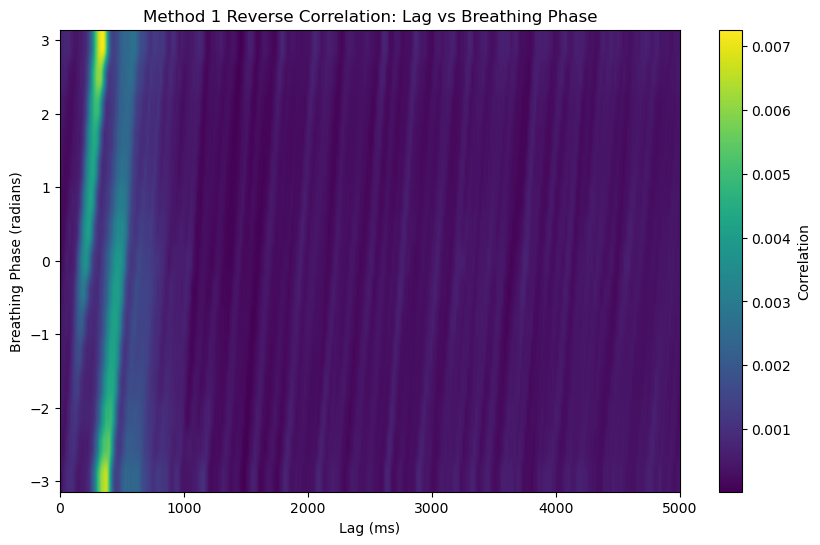

In [34]:
max_lag = 5000 #10s at 1000Hz 
n_phase_bins = 15

valve = valve_dict['HW1']
ca = ca_interp_dict['HW1'].mean(axis=1).to_numpy()
phase = instant_phase_dict['HW1']

rc_2d = reverse_correlation_2d(valve, ca, phase, max_lag, n_phase_bins)

plt.figure(figsize=(10, 6))
plt.imshow(rc_2d.T, aspect='auto', origin='lower', 
           extent=[0, max_lag, -np.pi, np.pi])
plt.colorbar(label='Correlation')
plt.title('Method 1 Reverse Correlation: Lag vs Breathing Phase')
plt.xlabel('Lag (ms)')
plt.ylabel('Breathing Phase (radians)')
plt.show()

Analysis: 
- neural response varies with the respiratory phase -> preferential responding during certain phases of breathing => strong respiratory influence

It increases from 0 to pi and decreases from -pi to 0
- strongest correlation in a lag between 300 and 400 ms -> response latency of the neuron (processing time)

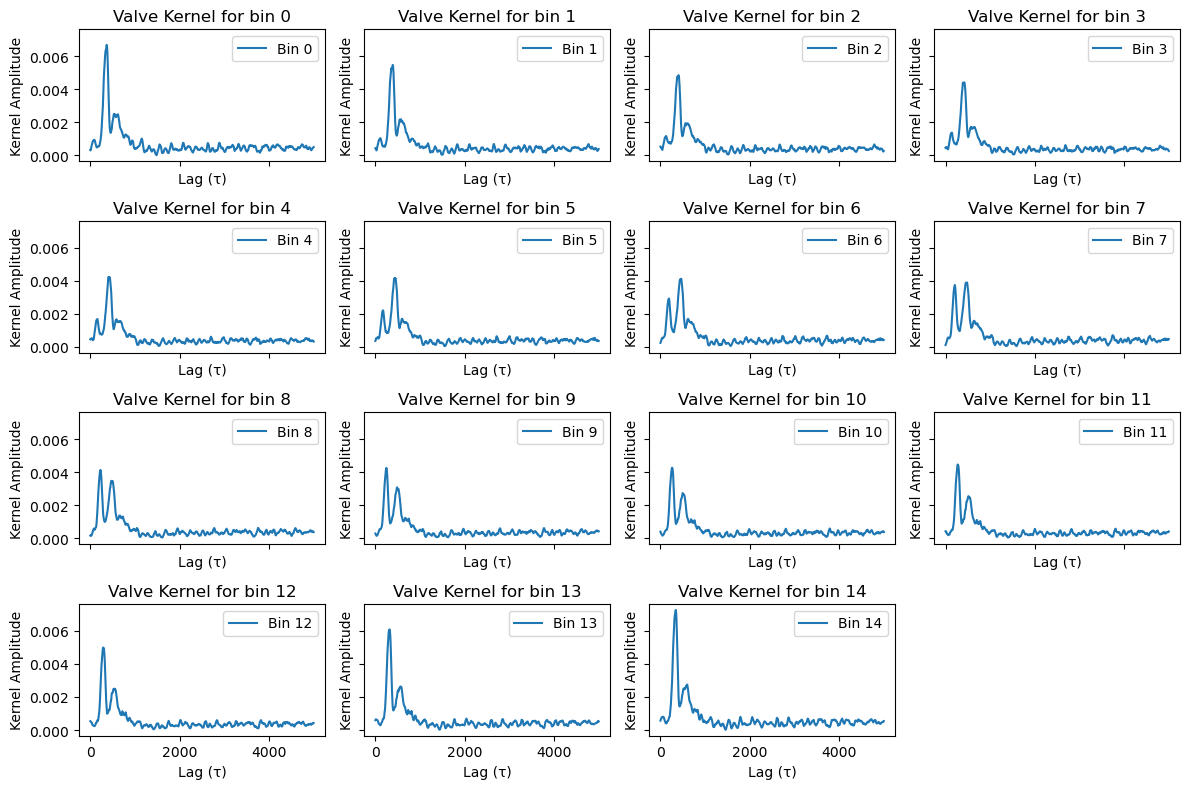

In [35]:
n_bins = len(rc_2d[0])  
ncols = 4 
nrows = (n_bins + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 2), sharex=True, sharey=True)

axes = axes.flatten()

for i in range(n_bins):
    axes[i].plot(rc_2d.T[i])
    axes[i].set_title(f'Valve Kernel for bin {i}')
    axes[i].set_xlabel('Lag (τ)')
    axes[i].set_ylabel('Kernel Amplitude')
    axes[i].legend([f'Bin {i}'])

for i in range(n_bins, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Analysis: 
- Strong immediate response to the stimulus
- Amplitude of the response varies across bins -> response strength depends on the breathing phase
- Overall shape is consitent: response dynamics don't change drastically across the breathing cycle

#### Test whether this is a good approx 

In [24]:
def split_data(pulse, ca, breath_phase, train_ratio=0.8):
    split_point = int(len(pulse) * train_ratio)
    return (pulse[:split_point], ca[:split_point], breath_phase[:split_point]), (pulse[split_point:], ca[split_point:], breath_phase[split_point:])

valve = valve_dict['HW1']
ca = ca_interp_dict['HW1'].mean(axis=1).to_numpy()
phase = instant_phase_dict['HW1']
(train_pulse, train_ca, train_phase), (test_pulse, test_ca, test_phase) = split_data(valve, ca, phase)

rc_2d_train = reverse_correlation_2d(train_pulse, train_ca, train_phase, max_lag, n_phase_bins)

In [25]:
def predict_response(pulse, breath_phase, rc_2d, max_lag, n_phase_bins):
    phase_bins = np.linspace(-np.pi, np.pi, n_phase_bins + 1)
    phase_indices = np.digitize(breath_phase, phase_bins) - 1
    
    predicted_response = np.zeros(len(pulse))
    print(len(pulse))
    
    for t in range(max_lag, len(pulse)):
        for lag in range(max_lag):
            predicted_response[t] += rc_2d[lag, phase_indices[t-lag]] * pulse[t-lag]
    
    return predicted_response

predicted_ca = predict_response(test_pulse, test_phase, rc_2d_train, max_lag, n_phase_bins)

424000


In [35]:
from scipy.stats import pearsonr

correlation, _ = pearsonr(predicted_ca[max_lag:], test_ca[max_lag:])
print(f"Correlation between predicted and actual responses: {correlation}")

Correlation between predicted and actual responses: 0.4967926128580644


In [26]:
print(predicted_ca.shape)
print(test_ca.shape)

(424000,)
(424000,)


In [27]:
ca_response_norm = (test_ca - np.min(test_ca)) / (np.max(test_ca) - np.min(test_ca))
predicted_response_norm = (predicted_ca - np.min(predicted_ca)) / (np.max(predicted_ca) - np.min(predicted_ca))

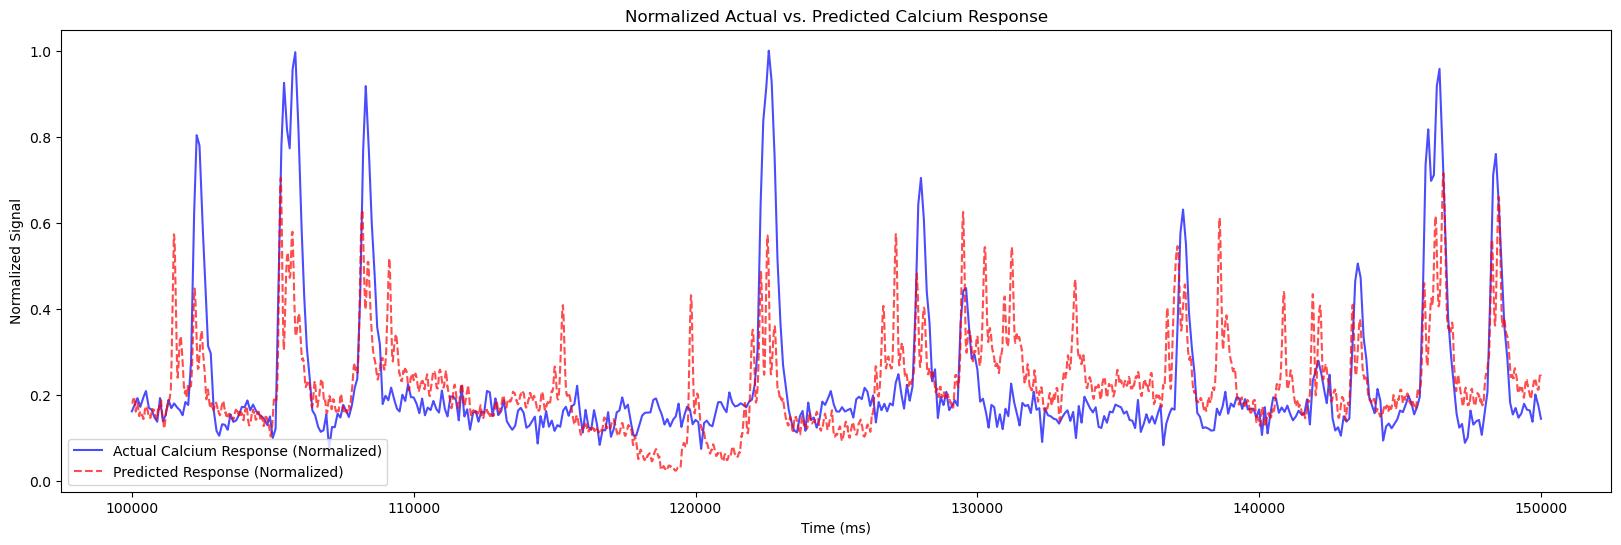

In [30]:
ca_response_norm = (test_ca - np.min(test_ca)) / (np.max(test_ca) - np.min(test_ca))
predicted_response_norm = (predicted_ca - np.min(predicted_ca)) / (np.max(predicted_ca) - np.min(predicted_ca))

plt.figure(figsize=(20, 6))
time = np.arange(len(test_ca))
plt.plot(time[100000:150000], ca_response_norm[100000:150000], label='Actual Calcium Response (Normalized)', color='blue', alpha=0.7)
plt.plot(time[100000:150000], predicted_response_norm[100000:150000], label='Predicted Response (Normalized)', color='red', linestyle='--', alpha=0.7)
plt.title('Normalized Actual vs. Predicted Calcium Response')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Signal')
plt.legend()
plt.show()

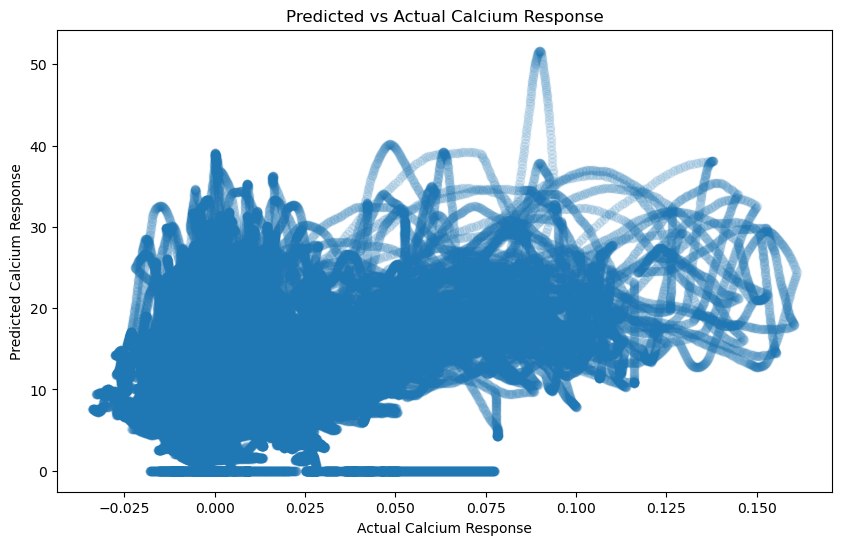

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(test_ca[max_lag:], predicted_ca[max_lag:], alpha=0.1)
plt.xlabel("Actual Calcium Response")
plt.ylabel("Predicted Calcium Response")
plt.title("Predicted vs Actual Calcium Response")
plt.show()

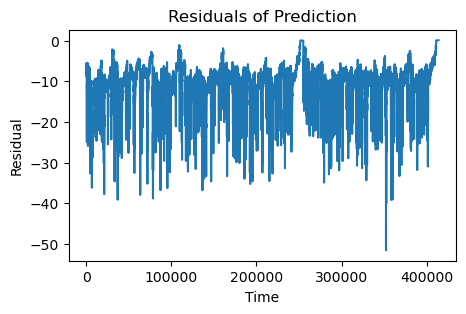

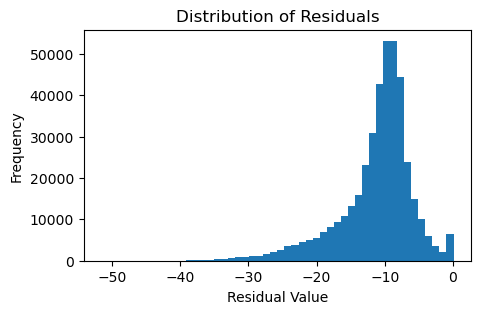

In [32]:
residuals = test_ca[max_lag:] - predicted_ca[max_lag:]

plt.figure(figsize=(5, 3))
plt.plot(residuals)
plt.xlabel("Time")
plt.ylabel("Residual")
plt.title("Residuals of Prediction")
plt.show()

plt.figure(figsize=(5, 3))
plt.hist(residuals, bins=50)
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


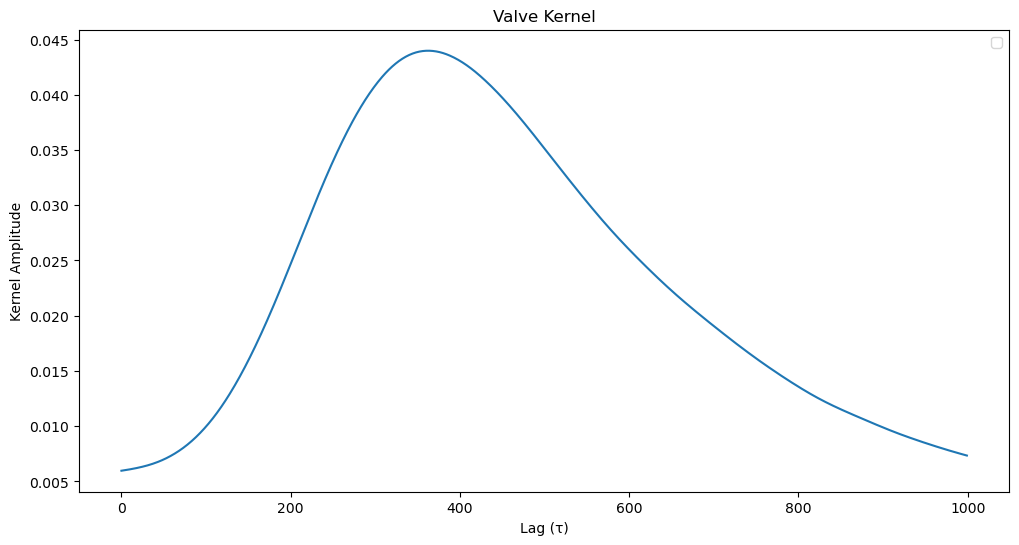

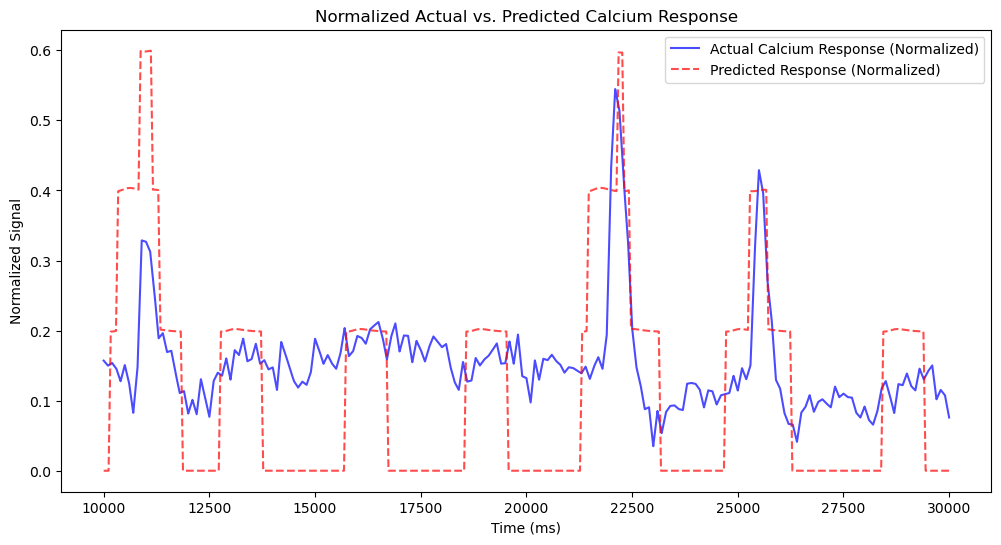

Cosine Similarity: 0.6443276364595909
Mean Squared Error (MSE): 0.02680444389127353
Correlation Coefficient: 0.28052369769231167


In [239]:
from scipy.fft import fft, ifft

tau_max = 1000
ca_response = ca_interp_dict['HW1'].mean(axis=1).to_numpy()
odor_pulse = valve_dict['HW1']/100
T = len(ca_response)

stimulus = odor_pulse
stimulus_variance = np.var(stimulus)

Q = np.zeros(tau_max)

# Compute response-weighted average using FFT convolution
conv_result = ifft(fft(ca_response) * np.conj(fft(stimulus))).real
Q = conv_result[:tau_max] / T  

D = Q / stimulus_variance

#calcium_signal = np.log1p(np.exp(D))  # Softplus
calcium_signal = 1 / (1 + np.exp(-D)) # # sigmoid (alternative)

predicted_response = np.convolve(stimulus, calcium_signal, mode='same')

ca_response_norm = (ca_response - np.min(ca_response)) / (np.max(ca_response) - np.min(ca_response))
predicted_response_norm = (predicted_response - np.min(predicted_response)) / (np.max(predicted_response) - np.min(predicted_response))


plt.figure(figsize=(12, 6))
plt.plot(D)
plt.title('Valve Kernel')
plt.xlabel('Lag (τ)')
plt.ylabel('Kernel Amplitude')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
time = np.arange(T)
plt.plot(time[10000:30000], ca_response_norm[10000:30000], label='Actual Calcium Response (Normalized)', color='blue', alpha=0.7)
plt.plot(time[10000:30000], predicted_response_norm[10000:30000], label='Predicted Response (Normalized)', color='red', linestyle='--', alpha=0.7)
plt.title('Normalized Actual vs. Predicted Calcium Response')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Signal')
plt.legend()
plt.show()

mse = np.mean((ca_response_norm - predicted_response_norm) ** 2)
correlation = np.corrcoef(ca_response_norm, predicted_response_norm)[0, 1]
similarity_score = cosine_similarity(ca_response_norm.reshape(1, -1), predicted_response_norm.reshape(1, -1))[0, 0]

print("Cosine Similarity:", similarity_score)
print("Mean Squared Error (MSE):", mse)
print("Correlation Coefficient:", correlation)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


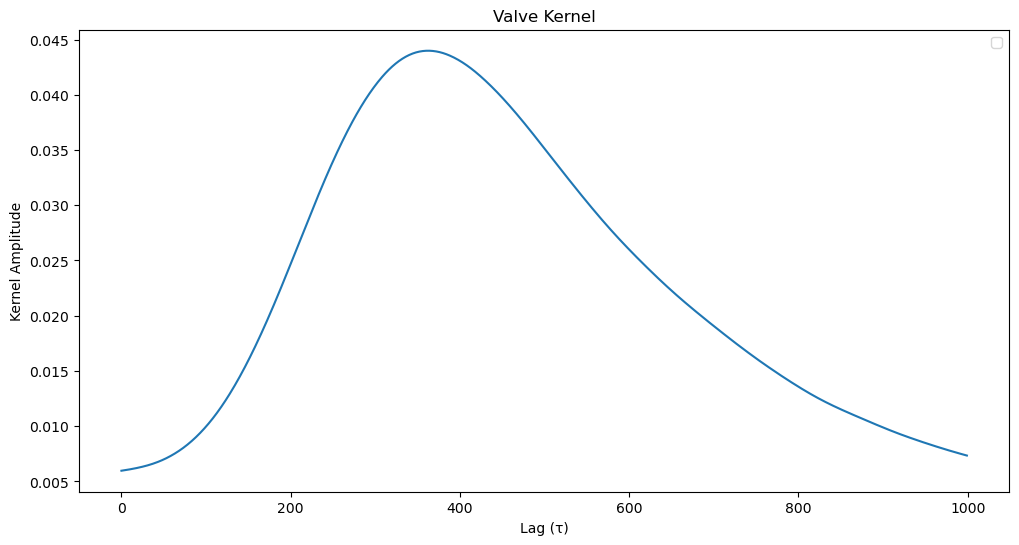

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


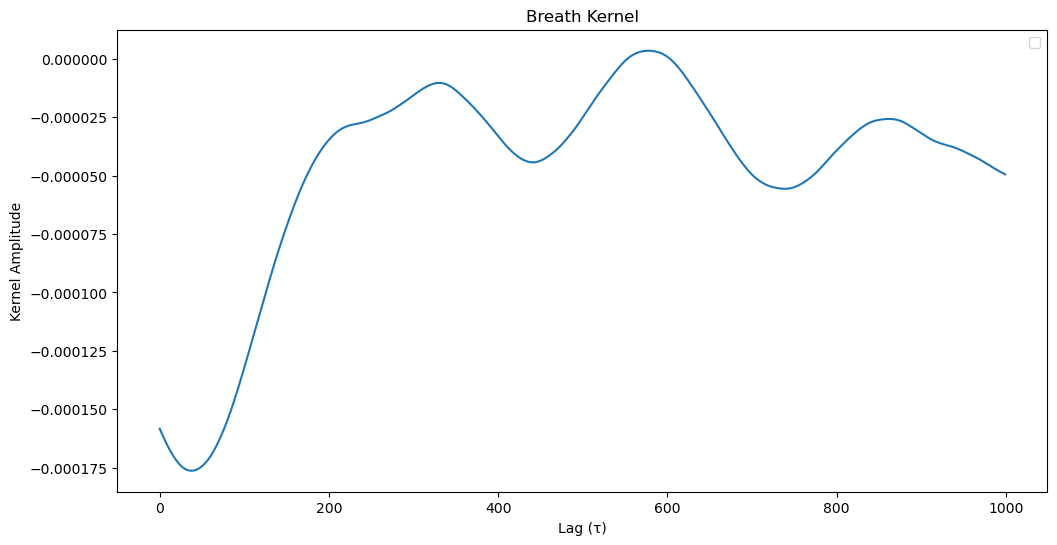

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


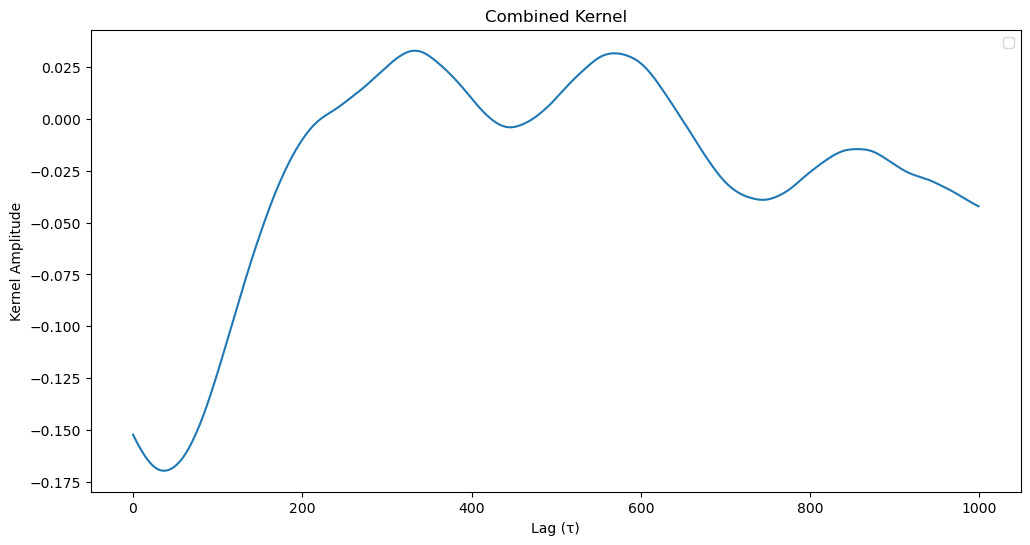

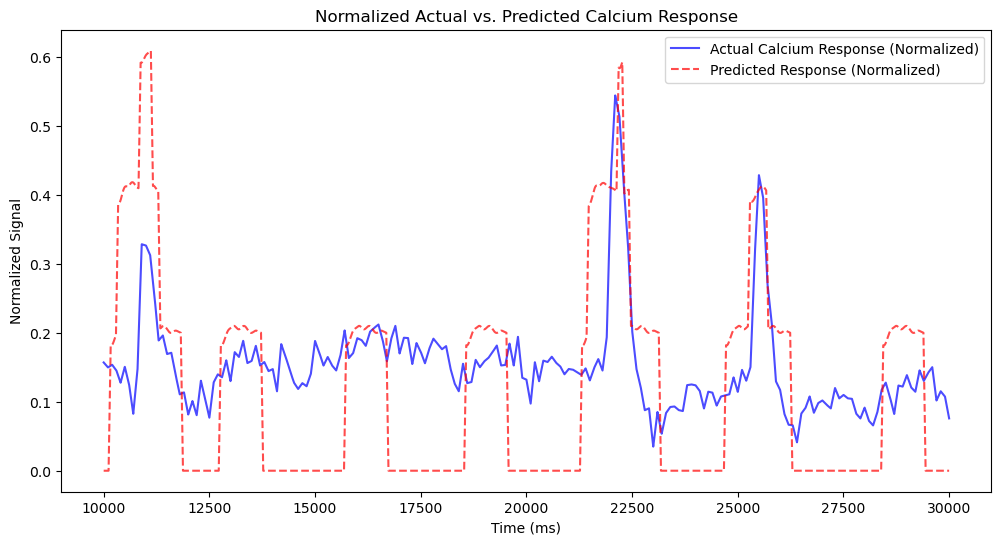

Cosine Similarity: 0.6443356443896325
Mean Squared Error (MSE): 0.027065179499130683
Correlation Coefficient: 0.28157640966828784


In [248]:
tau_max = 1000
ca_response = ca_interp_dict['HW1'].mean(axis=1).to_numpy()
odor_pulse = valve_dict['HW1']/100
breath_phase = instant_phase_dict['HW1']          
T = len(ca_response)

valve_variance = np.var(odor_pulse)
breath_phase_variance = np.var(breath_phase)

conv_result_breath = ifft(fft(ca_response) * np.conj(fft(breath_phase))).real
conv_result_valve = ifft(fft(ca_response) * np.conj(fft(odor_pulse))).real

Q_breath = conv_result_breath[:tau_max] / T
D_breath = Q_breath / breath_phase_variance

Q_valve = conv_result_valve[:tau_max] / T
D_valve = Q_valve / valve_variance

D_combined = D_valve + 1000*D_breath

# Apply nonlinearity
#calcium_signal = 1 / (1 + np.exp(-D_combined))  # sigmoid
calcium_signal = np.log1p(np.exp(D_combined))  # Softplus

predicted_response = np.convolve(stimulus, calcium_signal, mode='same')

ca_response_norm = (ca_response - np.min(ca_response)) / (np.max(ca_response) - np.min(ca_response))
predicted_response_norm = (predicted_response - np.min(predicted_response)) / (np.max(predicted_response) - np.min(predicted_response))


plt.figure(figsize=(12, 6))
plt.plot(D_valve)
plt.title('Valve Kernel')
plt.xlabel('Lag (τ)')
plt.ylabel('Kernel Amplitude')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(D_breath)
plt.title('Breath Kernel')
plt.xlabel('Lag (τ)')
plt.ylabel('Kernel Amplitude')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(D_combined)
plt.title('Combined Kernel')
plt.xlabel('Lag (τ)')
plt.ylabel('Kernel Amplitude')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
time = np.arange(T)
plt.plot(time[10000:30000], ca_response_norm[10000:30000], label='Actual Calcium Response (Normalized)', color='blue', alpha=0.7)
plt.plot(time[10000:30000], predicted_response_norm[10000:30000], label='Predicted Response (Normalized)', color='red', linestyle='--', alpha=0.7)
plt.title('Normalized Actual vs. Predicted Calcium Response')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Signal')
plt.legend()
plt.show()

mse = np.mean((ca_response_norm - predicted_response_norm) ** 2)
correlation = np.corrcoef(ca_response_norm, predicted_response_norm)[0, 1]
similarity_score = cosine_similarity(ca_response_norm.reshape(1, -1), predicted_response_norm.reshape(1, -1))[0, 0]

print("Cosine Similarity:", similarity_score)
print("Mean Squared Error (MSE):", mse)
print("Correlation Coefficient:", correlation)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2120000,)
(2120000,)
(2120000,)
(2120000,)


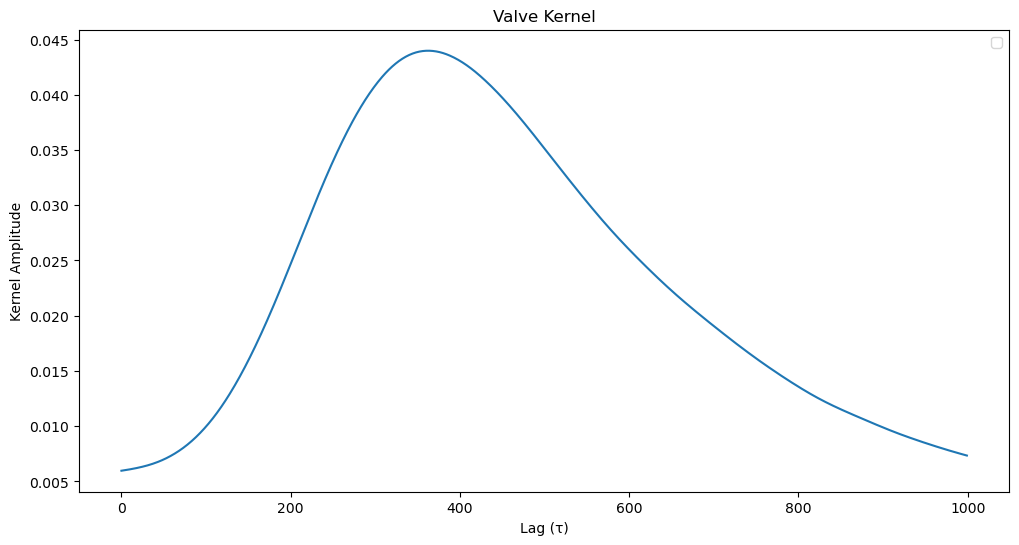

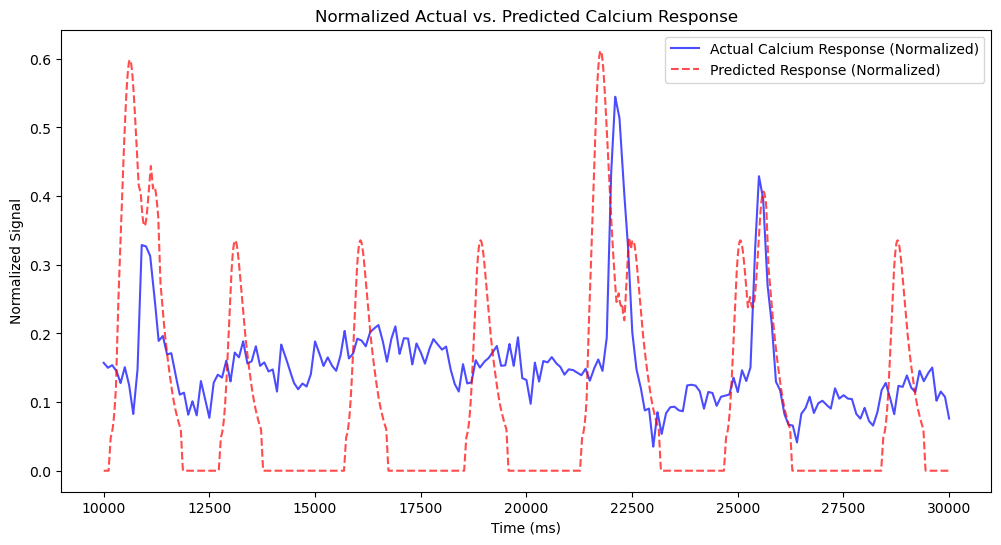

Cosine Similarity: 0.5349900624635939
Mean Squared Error (MSE): 0.03386492970128885
Correlation Coefficient: 0.11962344107422945


In [224]:
from scipy.fft import fft, ifft
from sklearn.metrics.pairwise import cosine_similarity

tau_max = 1000
ca_response = ca_interp_dict['HW1'].mean(axis=1).to_numpy()
odor_pulse = valve_dict['HW1']/100
T = len(ca_response)

stimulus = odor_pulse
stimulus_variance = np.var(stimulus)

Q = np.zeros(tau_max)

# Compute response-weighted average using FFT convolution
conv_result = ifft(fft(ca_response) * np.conj(fft(stimulus))).real
Q = conv_result[:tau_max] / T  

D = Q / stimulus_variance

predicted_response = np.convolve(stimulus, D, mode='same')

ca_response_norm = (ca_response - np.min(ca_response)) / (np.max(ca_response) - np.min(ca_response))
predicted_response_norm = (predicted_response - np.min(predicted_response)) / (np.max(predicted_response) - np.min(predicted_response))

print(ca_response.shape)
print(predicted_response.shape)
print(ca_response_norm.shape)
print(predicted_response_norm.shape)

plt.figure(figsize=(12, 6))
plt.plot(D)
plt.title('Valve Kernel')
plt.xlabel('Lag (τ)')
plt.ylabel('Kernel Amplitude')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
time = np.arange(T)
plt.plot(time[10000:30000], ca_response_norm[10000:30000], label='Actual Calcium Response (Normalized)', color='blue', alpha=0.7)
plt.plot(time[10000:30000], predicted_response_norm[10000:30000], label='Predicted Response (Normalized)', color='red', linestyle='--', alpha=0.7)
plt.title('Normalized Actual vs. Predicted Calcium Response')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Signal')
plt.legend()
plt.show()

mse = np.mean((ca_response_norm - predicted_response_norm) ** 2)
correlation = np.corrcoef(ca_response_norm, predicted_response_norm)[0, 1]
similarity_score = cosine_similarity(ca_response_norm.reshape(1, -1), predicted_response_norm.reshape(1, -1))[0, 0]

print("Cosine Similarity:", similarity_score)
print("Mean Squared Error (MSE):", mse)
print("Correlation Coefficient:", correlation)

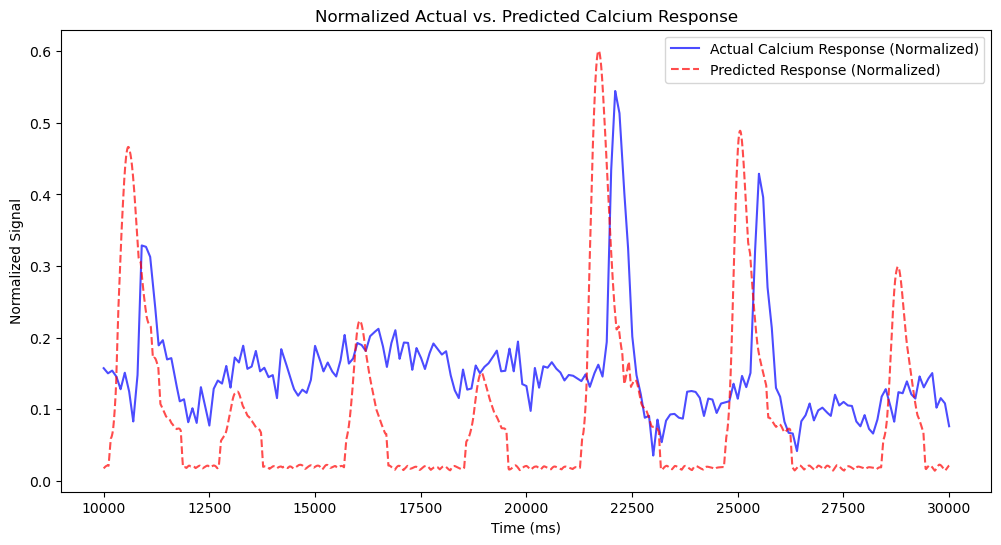

Cosine Similarity: 0.25033109327650443
Mean Squared Error (MSE): 0.029189594819465575
Correlation Coefficient: 0.14322299864155022


In [153]:
tau_max = 1000  # Maximum delay for kernel computation (in time steps)
ca_response = ca_interp_dict['HW1'].mean(axis=1).to_numpy()            
odor_pulse = valve_dict['HW1']              
breath_phase = instant_phase_dict['HW1']          
phase_odor = odor_pulse * breath_phase
T = len(ca_response)         

# Stimulus = breath+pulse 
stimulus = np.column_stack((odor_pulse, breath_phase, phase_odor)) 
stimulus_variance = np.var(stimulus, axis=0)

Q = np.zeros((3, tau_max))

# Compute the response-weighted average using FFT convolution
for i in range(3):
    # Convolve calcium response with each stimulus dimension using FFT
    conv_result = ifft(fft(ca_response) * np.conj(fft(stimulus[:, i]))).real
    Q[i, :] = conv_result[:tau_max] / T  

# Compute optimal kernel D
D = Q / stimulus_variance[:, None] 

# Convolve each stimulus signal with its kernel and sum for combined prediction
predicted_response = np.zeros(T)
for i in range(3):
    predicted_response += np.convolve(stimulus[:, i], D[i, :], mode='same')

# Normalize both actual and predicted responses to [0, 1] for easier comparison
ca_response_norm = (ca_response - np.min(ca_response)) / (np.max(ca_response) - np.min(ca_response))
predicted_response_norm = (predicted_response - np.min(predicted_response)) / (np.max(predicted_response) - np.min(predicted_response))

# Plot the normalized actual vs. predicted calcium response
plt.figure(figsize=(12, 6))
time = np.arange(T)
plt.plot(time[10000:30000], ca_response_norm[10000:30000], label='Actual Calcium Response (Normalized)', color='blue', alpha=0.7)
plt.plot(time[10000:30000], predicted_response_norm[10000:30000], label='Predicted Response (Normalized)', color='red', linestyle='--', alpha=0.7)
plt.title('Normalized Actual vs. Predicted Calcium Response')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Signal')
plt.legend()
plt.show()

mse = np.mean((ca_response_norm - predicted_response_norm) ** 2)
correlation = np.corrcoef(ca_response_norm, predicted_response_norm)[0, 1]
similarity_score = cosine_similarity([ca_response], [predicted_response])[0][0]

print("Cosine Similarity:", similarity_score)
print("Mean Squared Error (MSE):", mse)
print("Correlation Coefficient:", correlation)


#### Condition on range of pulses within long past interval

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


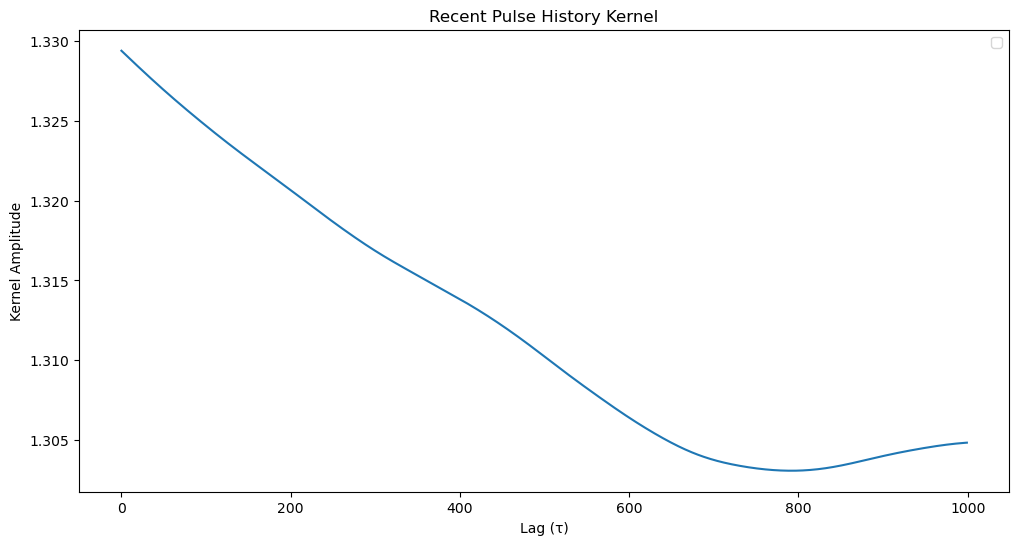

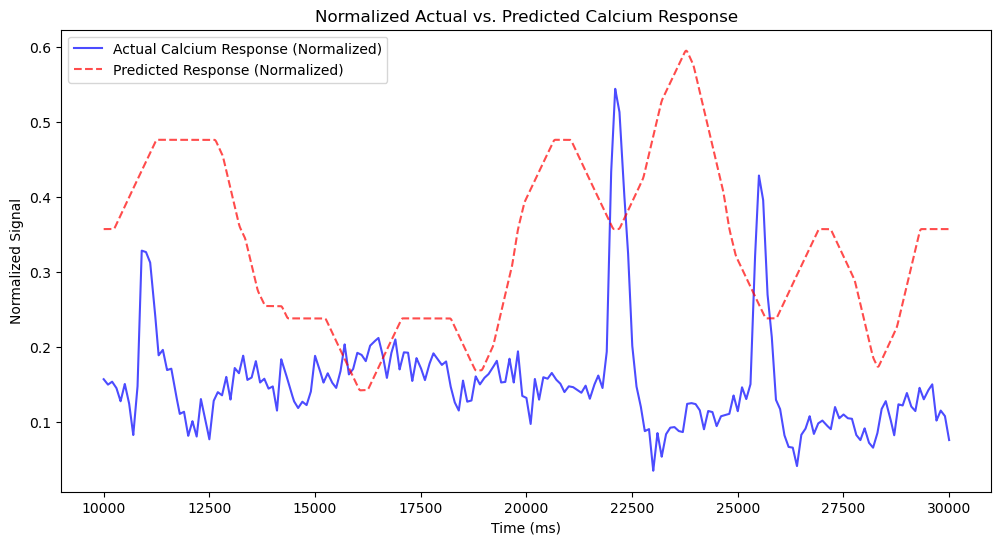

Cosine Similarity: 0.8182407335249456
Mean Squared Error (MSE): 0.06234102803631846
Correlation Coefficient: 0.1553591350344959


In [210]:
# Stimulus = breath + pulse + interaction + recent pulse history (10 s history)
sampling_rate = 1000  # Adjust this if the sampling rate is different
window_size = 5 * sampling_rate  # 10-second window size
recent_pulse_history = np.convolve(odor_pulse, np.ones(window_size), mode='same') / window_size # moving avg of odor_pulse over a window of 10s -> recent pulse history
# summarizes the cumulative pulse activity in the 10 s before each point

stimulus = recent_pulse_history
stimulus_variance = np.var(stimulus)

Q = np.zeros(tau_max)

# Compute response-weighted average using FFT convolution
conv_result = ifft(fft(ca_response) * np.conj(fft(stimulus))).real
Q = conv_result[:tau_max] / T  

D = Q / stimulus_variance

predicted_response = np.convolve(stimulus, D, mode='same')

ca_response_norm = (ca_response - np.min(ca_response)) / (np.max(ca_response) - np.min(ca_response))
predicted_response_norm = (predicted_response - np.min(predicted_response)) / (np.max(predicted_response) - np.min(predicted_response))

plt.figure(figsize=(12, 6))
plt.plot(D)
plt.title('Recent Pulse History Kernel')
plt.xlabel('Lag (τ)')
plt.ylabel('Kernel Amplitude')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
time = np.arange(T)
plt.plot(time[10000:30000], ca_response_norm[10000:30000], label='Actual Calcium Response (Normalized)', color='blue', alpha=0.7)
plt.plot(time[10000:30000], predicted_response_norm[10000:30000], label='Predicted Response (Normalized)', color='red', linestyle='--', alpha=0.7)
plt.title('Normalized Actual vs. Predicted Calcium Response')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Signal')
plt.legend()
plt.show()

mse = np.mean((ca_response_norm - predicted_response_norm) ** 2)
correlation = np.corrcoef(ca_response_norm, predicted_response_norm)[0, 1]
similarity_score = cosine_similarity(ca_response_norm.reshape(1, -1), predicted_response_norm.reshape(1, -1))[0, 0]

print("Cosine Similarity:", similarity_score)
print("Mean Squared Error (MSE):", mse)
print("Correlation Coefficient:", correlation)

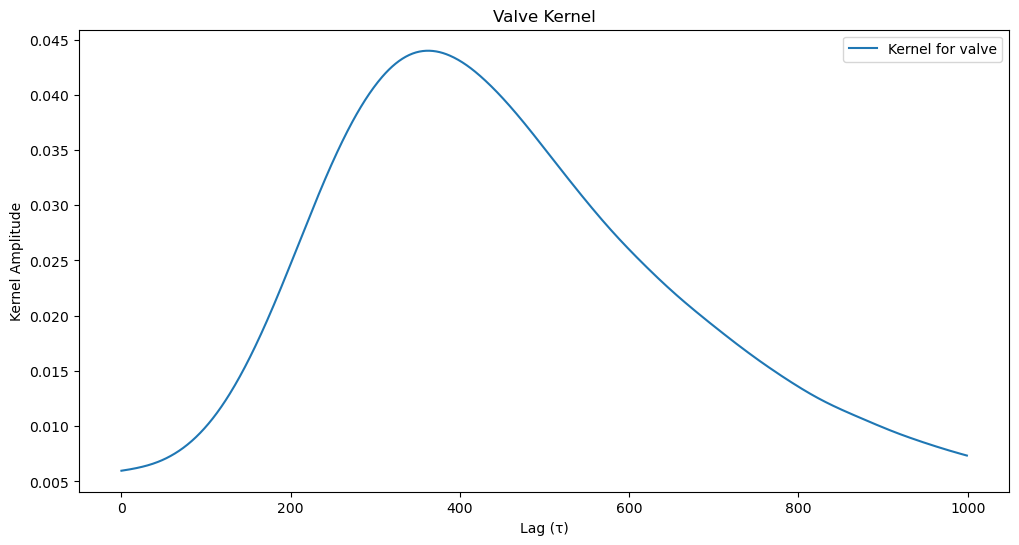

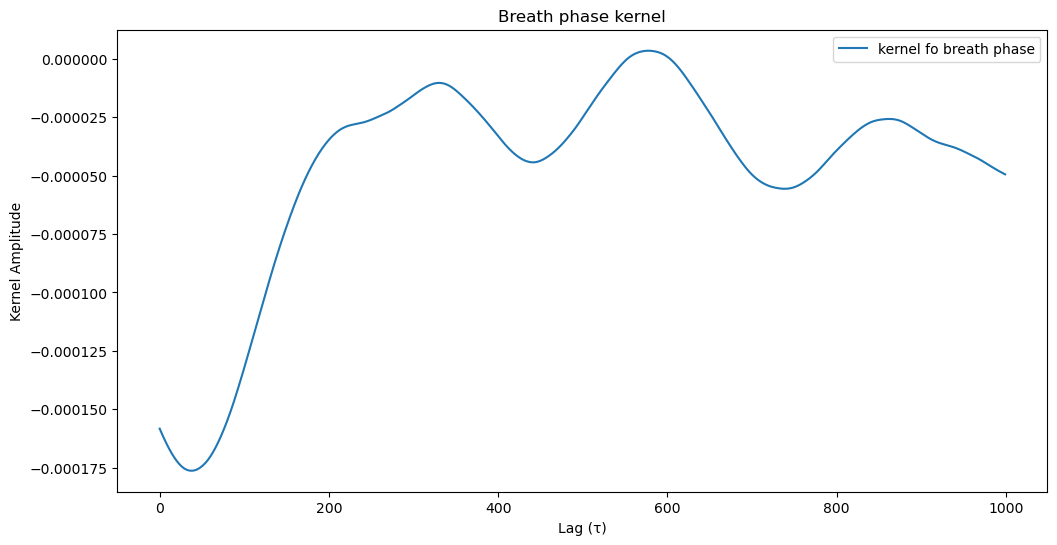

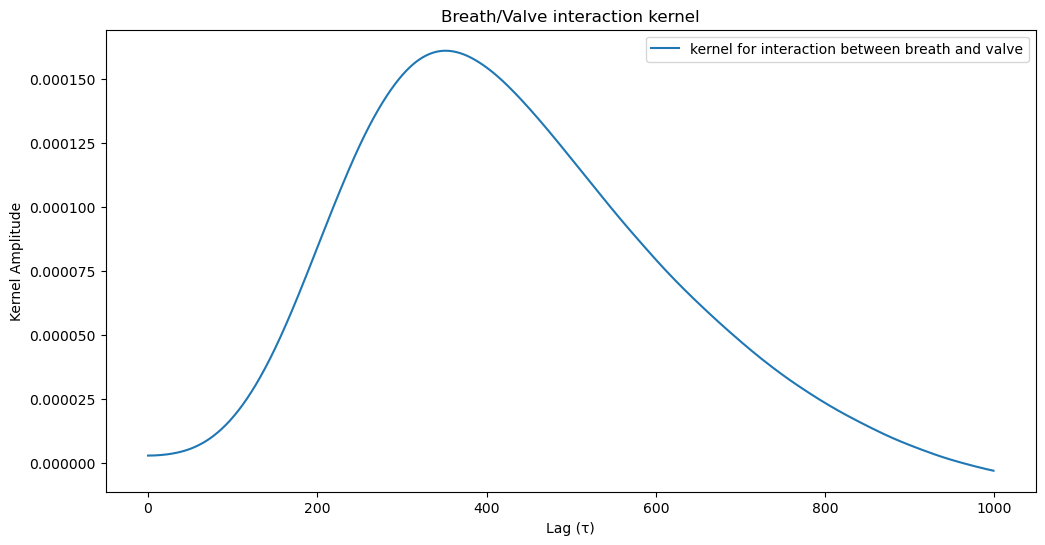

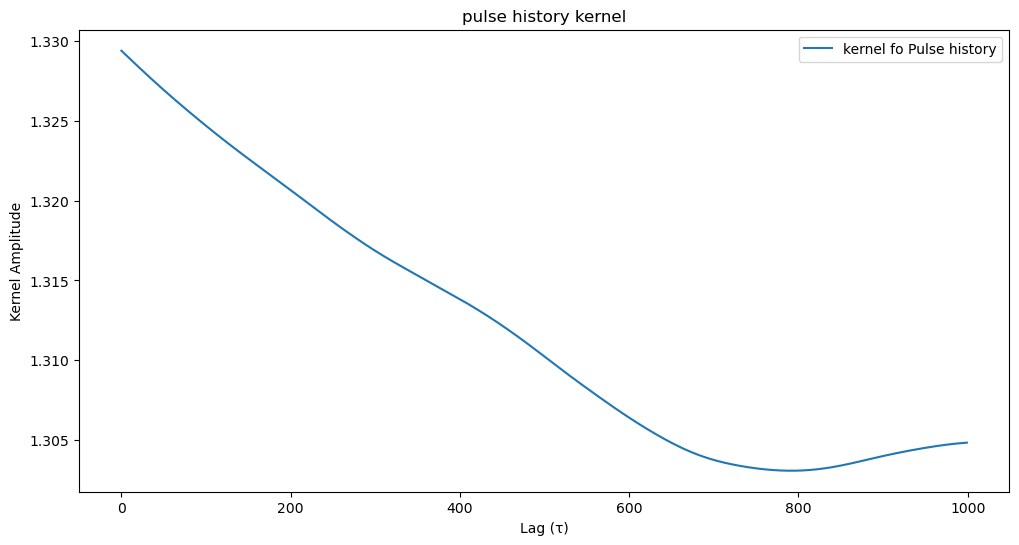

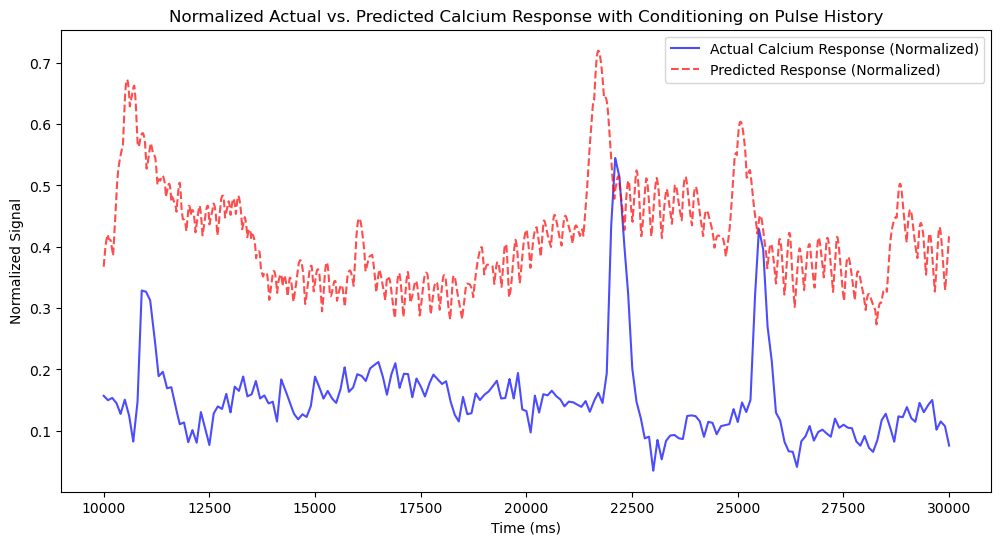

Cosine Similarity: 0.2833483821789649
Mean Squared Error (MSE): 2.262809923607548
Correlation Coefficient: 0.19316563711015045


In [213]:
# Stimulus = breath + pulse + interaction + recent pulse history (10 s history)
sampling_rate = 1000  # Adjust this if the sampling rate is different
window_size = 5 * sampling_rate  # 10-second window size
recent_pulse_history = np.convolve(odor_pulse, np.ones(window_size), mode='same') / window_size # moving avg of odor_pulse over a window of 10s -> recent pulse history
# summarizes the cumulative pulse activity in the 10 s before each point

stimulus = np.column_stack((odor_pulse, breath_phase, phase_odor, recent_pulse_history))
stimulus_variance = np.var(stimulus, axis=0)

Q = np.zeros((4, tau_max))

# Compute the response-weighted average using FFT convolution
for i in range(4):
    # Convolve calcium response with each stimulus dimension using FFT
    conv_result = ifft(fft(ca_response) * np.conj(fft(stimulus[:, i]))).real
    Q[i, :] = conv_result[:tau_max] / T  

D = Q / stimulus_variance[:, None] 

# Convolve each stimulus signal with its kernel and sum for combined prediction
predicted_response = np.zeros(T)
for i in range(4):
    component_response = np.convolve(stimulus[:, i], D[i, :], mode='same')
    component_response_norm = (component_response-np.min(component_response)) / (np.max(component_response)-np.min(component_response))
    predicted_response += component_response_norm

ca_response_norm = (ca_response - np.min(ca_response)) / (np.max(ca_response) - np.min(ca_response))
predicted_response_norm = (predicted_response - np.min(predicted_response)) / (np.max(predicted_response) - np.min(predicted_response))

plt.figure(figsize=(12, 6))
plt.plot(D[0, :], label=f'Kernel for valve')
plt.title('Valve Kernel')
plt.xlabel('Lag (τ)')
plt.ylabel('Kernel Amplitude')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(D[1, :], label=f'kernel fo breath phase')
plt.title('Breath phase kernel')
plt.xlabel('Lag (τ)')
plt.ylabel('Kernel Amplitude')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(D[2, :], label=f'kernel for interaction between breath and valve')
plt.title('Breath/Valve interaction kernel')
plt.xlabel('Lag (τ)')
plt.ylabel('Kernel Amplitude')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(D[3, :], label=f'kernel fo Pulse history')
plt.title('pulse history kernel')
plt.xlabel('Lag (τ)')
plt.ylabel('Kernel Amplitude')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
time = np.arange(T)
plt.plot(time[10000:30000], ca_response_norm[10000:30000], label='Actual Calcium Response (Normalized)', color='blue', alpha=0.7)
plt.plot(time[10000:30000], predicted_response_norm[10000:30000], label='Predicted Response (Normalized)', color='red', linestyle='--', alpha=0.7)
plt.title('Normalized Actual vs. Predicted Calcium Response with Conditioning on Pulse History')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Signal')
plt.legend()
plt.show()

mse = np.mean((ca_response - predicted_response) ** 2)
correlation = np.corrcoef(ca_response, predicted_response)[0, 1]
similarity_score = cosine_similarity([ca_response], [predicted_response])[0][0]

print(f"Cosine Similarity: {similarity_score}")
print("Mean Squared Error (MSE):", mse)
print("Correlation Coefficient:", correlation)


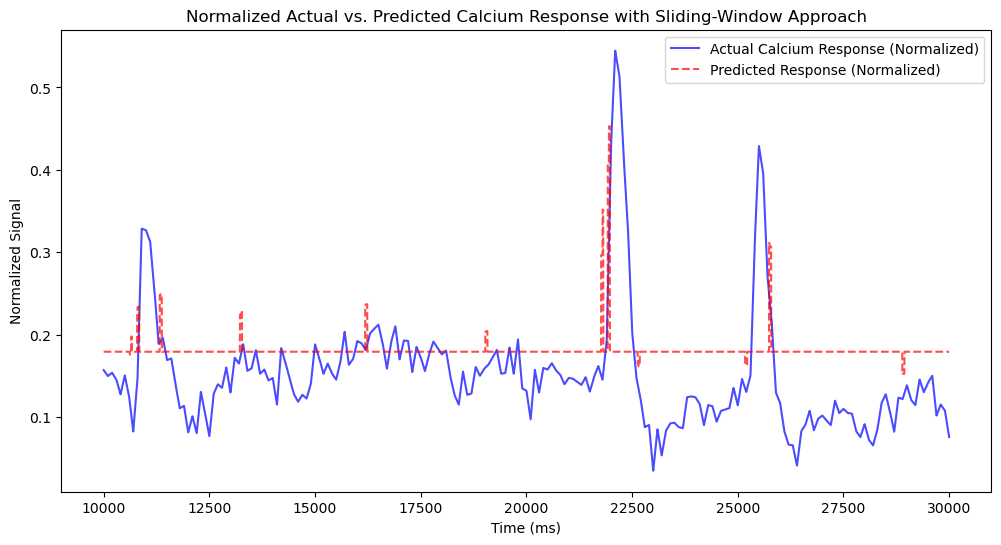

Mean Squared Error (MSE): 0.0007439865467550977
Correlation Coefficient: 0.13369902874264875


In [261]:
# Condition on previous time intervals: method of https://elifesciences.org/articles/27670

N = 500  # window size to look back at recent pulses)
stride = 50  # Step size for calculating kernel
T = len(ca_response)

K = np.zeros(N)  # Kernel with length N
predicted_response = np.zeros(T)

for t in range(N, T, stride):
    # Define the window for recent past pulses
    window_start = max(0, t - N)
    window_end = t
    
    S_window = odor_pulse[window_start:window_end]
    R_window = ca_response[window_start:window_end]
    
    # kernel using least squares 
    if len(S_window) >= N:
        K, _, _, _ = np.linalg.lstsq(S_window.reshape(-1, 1), R_window, rcond=None)
    
    predicted_response[window_start:window_end] = S_window * K

ca_response_norm = (ca_response - np.min(ca_response)) / (np.max(ca_response) - np.min(ca_response))
predicted_response_norm = (predicted_response - np.min(predicted_response)) / (np.max(predicted_response) - np.min(predicted_response))

plt.figure(figsize=(12, 6))
time = np.arange(T)
plt.plot(time[10000:30000], ca_response_norm[10000:30000], label='Actual Calcium Response (Normalized)', color='blue', alpha=0.7)
plt.plot(time[10000:30000], predicted_response_norm[10000:30000], label='Predicted Response (Normalized)', color='red', linestyle='--', alpha=0.7)
plt.title('Normalized Actual vs. Predicted Calcium Response with Sliding-Window Approach')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Signal')
plt.legend()
plt.show()

mse = np.mean((ca_response - predicted_response) ** 2)
correlation = np.corrcoef(ca_response, predicted_response)[0, 1]

print("Mean Squared Error (MSE):", mse)
print("Correlation Coefficient:", correlation)
